# 🧠 HRHUB v2.1 - Enhanced with LLM (FREE VERSION)

## 📘 Project Overview

**Bilateral HR Matching System with LLM-Powered Intelligence**

### What's New in v2.1:
- ✅ **FREE LLM**: Using Hugging Face Inference API (no cost)
- ✅ **Job Level Classification**: Zero-shot & few-shot learning
- ✅ **Structured Skills Extraction**: Pydantic schemas
- ✅ **Match Explainability**: LLM-generated reasoning
- ✅ **Flexible Data Loading**: Upload OR Google Drive

### Tech Stack:
```
Embeddings: sentence-transformers (local, free)
LLM: Hugging Face Inference API (free tier)
Schemas: Pydantic
Platform: Google Colab → VS Code
```

---

**Master's Thesis - Aalborg University**  
*Business Data Science Program*  
*December 2025*

---
## 📊 Step 1: Install Dependencies

In [1]:
# Install required packages
#!pip install -q sentence-transformers huggingface-hub pydantic plotly pyvis nbformat scikit-learn pandas numpy

print("✅ All packages installed!")

✅ All packages installed!


---
## 📊 Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import json
import os
from typing import List, Dict, Optional, Literal
import warnings
warnings.filterwarnings('ignore')

# ML & NLP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# LLM Integration (FREE)
from huggingface_hub import InferenceClient
from pydantic import BaseModel, Field

# Visualization
import plotly.graph_objects as go
from IPython.display import HTML, display

# Configuration Settings
from dotenv import load_dotenv

# Carrega variáveis do .env
load_dotenv()
print("✅ Environment variables loaded from .env")

print("✅ All libraries imported!")

✅ Environment variables loaded from .env
✅ All libraries imported!


---
## 📊 Step 3: Configuration

In [3]:
class Config:
    """Centralized configuration for VS Code"""
    
    # Paths - VS Code structure
    CSV_PATH = '../csv_files/'
    PROCESSED_PATH = '../processed/'
    RESULTS_PATH = '../results/'
    
    # Embedding Model
    EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
    
    # LLM Settings (FREE - Hugging Face)
    HF_TOKEN = os.getenv('HF_TOKEN', '')  # ✅ Pega do .env
    LLM_MODEL = 'meta-llama/Llama-3.2-3B-Instruct'
    
    LLM_MAX_TOKENS = 1000
    
    # Matching Parameters
    TOP_K_MATCHES = 10
    SIMILARITY_THRESHOLD = 0.5
    RANDOM_SEED = 42

np.random.seed(Config.RANDOM_SEED)

print("✅ Configuration loaded!")
print(f"🧠 Embedding model: {Config.EMBEDDING_MODEL}")
print(f"🤖 LLM model: {Config.LLM_MODEL}")
print(f"🔑 HF Token configured: {'Yes ✅' if Config.HF_TOKEN else 'No ⚠️'}")
print(f"📂 Data path: {Config.CSV_PATH}")

✅ Configuration loaded!
🧠 Embedding model: all-MiniLM-L6-v2
🤖 LLM model: meta-llama/Llama-3.2-3B-Instruct
🔑 HF Token configured: Yes ✅
📂 Data path: ../csv_files/


---
## 🏗️ Step 4: Architecture - Text Builders

**HIGH COHESION:** Each class has ONE responsibility
**LOW COUPLING:** Classes don't depend on each other

In [4]:
# ============================================================================
# TEXT BUILDER CLASSES - Single Responsibility Principle
# ============================================================================

from abc import ABC, abstractmethod
from typing import List

class TextBuilder(ABC):
    """Abstract base class for text builders"""
    
    @abstractmethod
    def build(self, row: pd.Series) -> str:
        """Build text representation from DataFrame row"""
        pass
    
    def build_batch(self, df: pd.DataFrame) -> List[str]:
        """Build text representations for entire DataFrame"""
        return df.apply(self.build, axis=1).tolist()


class CandidateTextBuilder(TextBuilder):
    """Builds text representation for candidates"""
    
    def __init__(self, fields: List[str] = None):
        self.fields = fields or [
            'Category',
            'skills',
            'career_objective',
            'degree_names',
            'positions'
        ]
    
    def build(self, row: pd.Series) -> str:
        parts = []
        
        if row.get('Category'):
            parts.append(f"Job Category: {row['Category']}")
        
        if row.get('skills'):
            parts.append(f"Skills: {row['skills']}")
        
        if row.get('career_objective'):
            parts.append(f"Objective: {row['career_objective']}")
        
        if row.get('degree_names'):
            parts.append(f"Education: {row['degree_names']}")
        
        if row.get('positions'):
            parts.append(f"Experience: {row['positions']}")
        
        return ' '.join(parts)


class CompanyTextBuilder(TextBuilder):
    """Builds text representation for companies"""
    
    def __init__(self, include_postings: bool = True):
        self.include_postings = include_postings
    
    def build(self, row: pd.Series) -> str:
        parts = []
        
        if row.get('name'):
            parts.append(f"Company: {row['name']}")
        
        if row.get('description'):
            parts.append(f"Description: {row['description']}")
        
        if row.get('industries_list'):
            parts.append(f"Industries: {row['industries_list']}")
        
        if row.get('specialties_list'):
            parts.append(f"Specialties: {row['specialties_list']}")
        
        # Include job postings data (THE BRIDGE!)
        if self.include_postings:
            if row.get('required_skills'):
                parts.append(f"Required Skills: {row['required_skills']}")
            
            if row.get('posted_job_titles'):
                parts.append(f"Job Titles: {row['posted_job_titles']}")
            
            if row.get('experience_levels'):
                parts.append(f"Experience: {row['experience_levels']}")
        
        return ' '.join(parts)


print("✅ Text Builder classes loaded")
print("   • CandidateTextBuilder")
print("   • CompanyTextBuilder")

✅ Text Builder classes loaded
   • CandidateTextBuilder
   • CompanyTextBuilder


---
## 🏗️ Step 5: Architecture - Embedding Manager

**Responsibility:** Generate, save, and load embeddings

In [5]:
# ============================================================================
# EMBEDDING MANAGER - Handles all embedding operations
# ============================================================================

from pathlib import Path
from typing import Tuple, Optional

class EmbeddingManager:
    """Manages embedding generation, saving, and loading"""
    
    def __init__(self, model: SentenceTransformer, save_dir: str):
        self.model = model
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
    
    def _get_file_paths(self, entity_type: str) -> Tuple[Path, Path]:
        """Get file paths for embeddings and metadata"""
        emb_file = self.save_dir / f"{entity_type}_embeddings.npy"
        meta_file = self.save_dir / f"{entity_type}_metadata.pkl"
        return emb_file, meta_file
    
    def exists(self, entity_type: str) -> bool:
        """Check if embeddings exist for entity type"""
        emb_file, _ = self._get_file_paths(entity_type)
        return emb_file.exists()
    
    def load(self, entity_type: str) -> Tuple[np.ndarray, pd.DataFrame]:
        """Load embeddings and metadata"""
        emb_file, meta_file = self._get_file_paths(entity_type)
        
        if not emb_file.exists():
            raise FileNotFoundError(f"Embeddings not found: {emb_file}")
        
        embeddings = np.load(emb_file)
        metadata = pd.read_pickle(meta_file) if meta_file.exists() else None
        
        return embeddings, metadata
    
    def generate(self,
                texts: List[str],
                batch_size: int = 32,
                show_progress: bool = True) -> np.ndarray:
        """Generate embeddings from texts"""
        return self.model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=show_progress,
            normalize_embeddings=True,
            convert_to_numpy=True
        )
    
    def save(self,
            entity_type: str,
            embeddings: np.ndarray,
            metadata: pd.DataFrame) -> None:
        """Save embeddings and metadata"""
        emb_file, meta_file = self._get_file_paths(entity_type)
        
        np.save(emb_file, embeddings)
        metadata.to_pickle(meta_file)
        
        print(f"💾 Saved:")
        print(f"   {emb_file}")
        print(f"   {meta_file}")
    
    def generate_and_save(self,
                         entity_type: str,
                         texts: List[str],
                         metadata: pd.DataFrame,
                         batch_size: int = 32) -> np.ndarray:
        """Generate embeddings and save everything"""
        print(f"🔄 Generating {entity_type} embeddings...")
        print(f"   Processing {len(texts):,} items...")
        
        embeddings = self.generate(texts, batch_size=batch_size)
        self.save(entity_type, embeddings, metadata)
        
        return embeddings
    
    def load_or_generate(self,
                        entity_type: str,
                        texts: List[str],
                        metadata: pd.DataFrame,
                        force_regenerate: bool = False) -> Tuple[np.ndarray, pd.DataFrame]:
        """Load if exists, generate otherwise"""
        
        if not force_regenerate and self.exists(entity_type):
            print(f"📥 Loading {entity_type} embeddings...")
            embeddings, saved_metadata = self.load(entity_type)
            
            # Verify alignment
            if len(embeddings) != len(metadata):
                print(f"⚠️  Size mismatch! Regenerating...")
                embeddings = self.generate_and_save(
                    entity_type, texts, metadata
                )
            else:
                print(f"✅ Loaded: {embeddings.shape}")
        else:
            embeddings = self.generate_and_save(
                entity_type, texts, metadata
            )
        
        return embeddings, metadata


print("✅ EmbeddingManager class loaded")

✅ EmbeddingManager class loaded


---
## 🏗️ Step 6: Architecture - Matching Engine

**Responsibility:** Calculate similarities and find matches

In [6]:
# ============================================================================
# MATCHING ENGINE - Handles similarity calculations
# ============================================================================

class MatchingEngine:
    """Calculates similarities and finds top matches"""
    
    def __init__(self,
                candidate_vectors: np.ndarray,
                company_vectors: np.ndarray,
                candidate_metadata: pd.DataFrame,
                company_metadata: pd.DataFrame):
        
        self.cand_vectors = candidate_vectors
        self.comp_vectors = company_vectors
        self.cand_metadata = candidate_metadata
        self.comp_metadata = company_metadata
        
        # Verify alignment
        assert len(candidate_vectors) == len(candidate_metadata), \
            "Candidate embeddings and metadata size mismatch"
        assert len(company_vectors) == len(company_metadata), \
            "Company embeddings and metadata size mismatch"
    
    def find_matches(self,
                    candidate_idx: int,
                    top_k: int = 10) -> List[Tuple[int, float]]:
        """Find top K company matches for a candidate"""
        
        if candidate_idx >= len(self.cand_vectors):
            raise IndexError(f"Candidate index {candidate_idx} out of range")
        
        # Get candidate vector
        cand_vec = self.cand_vectors[candidate_idx].reshape(1, -1)
        
        # Calculate similarities
        similarities = cosine_similarity(cand_vec, self.comp_vectors)[0]
        
        # Get top K
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # Return (index, score) tuples
        return [(int(idx), float(similarities[idx])) for idx in top_indices]
    
    def get_match_details(self,
                         candidate_idx: int,
                         company_idx: int) -> dict:
        """Get detailed match information"""
        
        candidate = self.cand_metadata.iloc[candidate_idx]
        company = self.comp_metadata.iloc[company_idx]
        
        # Calculate similarity
        cand_vec = self.cand_vectors[candidate_idx].reshape(1, -1)
        comp_vec = self.comp_vectors[company_idx].reshape(1, -1)
        similarity = float(cosine_similarity(cand_vec, comp_vec)[0][0])
        
        return {
            'candidate': candidate.to_dict(),
            'company': company.to_dict(),
            'similarity_score': similarity
        }
    
    def batch_match(self,
                   candidate_indices: List[int],
                   top_k: int = 10) -> dict:
        """Find matches for multiple candidates"""
        
        results = {}
        for idx in candidate_indices:
            results[idx] = self.find_matches(idx, top_k=top_k)
        
        return results


print("✅ MatchingEngine class loaded")

✅ MatchingEngine class loaded


---
## 📊 Step 7: Load All Datasets

In [7]:
print("📂 Loading all datasets...\n")
print("=" * 70)

# Load main datasets
candidates = pd.read_csv(f'{Config.CSV_PATH}resume_data.csv')
print(f"✅ Candidates: {len(candidates):,} rows × {len(candidates.columns)} columns")

companies_base = pd.read_csv(f'{Config.CSV_PATH}companies.csv')
print(f"✅ Companies (base): {len(companies_base):,} rows")

company_industries = pd.read_csv(f'{Config.CSV_PATH}company_industries.csv')
print(f"✅ Company industries: {len(company_industries):,} rows")

company_specialties = pd.read_csv(f'{Config.CSV_PATH}company_specialities.csv')
print(f"✅ Company specialties: {len(company_specialties):,} rows")

employee_counts = pd.read_csv(f'{Config.CSV_PATH}employee_counts.csv')
print(f"✅ Employee counts: {len(employee_counts):,} rows")

postings = pd.read_csv(f'{Config.CSV_PATH}postings.csv', on_bad_lines='skip', engine='python')
print(f"✅ Postings: {len(postings):,} rows × {len(postings.columns)} columns")

# Optional datasets
try:
    job_skills = pd.read_csv(f'{Config.CSV_PATH}job_skills.csv')
    print(f"✅ Job skills: {len(job_skills):,} rows")
except:
    job_skills = None
    print("⚠️  Job skills not found (optional)")

try:
    job_industries = pd.read_csv(f'{Config.CSV_PATH}job_industries.csv')
    print(f"✅ Job industries: {len(job_industries):,} rows")
except:
    job_industries = None
    print("⚠️  Job industries not found (optional)")

print("\n" + "=" * 70)
print("✅ All datasets loaded successfully!\n")

📂 Loading all datasets...

✅ Candidates: 9,544 rows × 35 columns
✅ Companies (base): 24,473 rows
✅ Company industries: 24,375 rows
✅ Company specialties: 169,387 rows
✅ Employee counts: 35,787 rows
✅ Postings: 123,849 rows × 31 columns
✅ Job skills: 213,768 rows
✅ Job industries: 164,808 rows

✅ All datasets loaded successfully!



---
## 📊 Step 8: Merge & Enrich Company Data

In [8]:
# ═══════════════════════════════════════════════════════════════════
# CELL 8: Merge & Enrich Company Data + Empty Columns Validation
# ═══════════════════════════════════════════════════════════════════

print("🔄 ENRICHING COMPANY DATA...")
print("=" * 80)

# ============================================================================
# STEP 1: Aggregate Industries per Company
# ============================================================================
print("\n1️⃣  Aggregating industries...")

industries_grouped = company_industries.groupby('company_id')['industry'].apply(
    lambda x: ', '.join(x.dropna().astype(str).unique())
).reset_index()
industries_grouped.columns = ['company_id', 'industries_list']

print(f"✅ Industries aggregated: {len(industries_grouped):,} companies")

# ============================================================================
# STEP 2: Aggregate Specialties per Company
# ============================================================================
print("\n2️⃣  Aggregating specialties...")

specialties_grouped = company_specialties.groupby('company_id')['speciality'].apply(
    lambda x: ', '.join(x.dropna().astype(str).unique())
).reset_index()
specialties_grouped.columns = ['company_id', 'specialties_list']

print(f"✅ Specialties aggregated: {len(specialties_grouped):,} companies")

# ============================================================================
# STEP 3: Aggregate Skills from Job Postings
# ============================================================================
print("\n3️⃣  Aggregating job posting skills...")

if job_skills is not None:
    skills_df = pd.read_csv(f'{Config.CSV_PATH}skills.csv')
    
    job_skills_enriched = job_skills.merge(
        skills_df,
        on='skill_abr',
        how='left'
    )
    
    skills_per_posting = job_skills_enriched.groupby('job_id')['skill_name'].apply(
        lambda x: ', '.join(x.dropna().astype(str).unique())
    ).reset_index()
    skills_per_posting.columns = ['job_id', 'required_skills']
    
    print(f"✅ Skills aggregated: {len(skills_per_posting):,} job postings")
else:
    skills_per_posting = pd.DataFrame(columns=['job_id', 'required_skills'])
    print("⚠️  Job skills not available")

# ============================================================================
# STEP 4: Aggregate Job Posting Data per Company
# ============================================================================
print("\n4️⃣  Aggregating job postings...")

postings_enriched = postings.merge(skills_per_posting, on='job_id', how='left')

job_data_grouped = postings_enriched.groupby('company_id').agg({
    'title': lambda x: ', '.join(x.dropna().astype(str).unique()[:10]),
    'required_skills': lambda x: ', '.join(x.dropna().astype(str).unique()),
    'med_salary': 'mean',
    'max_salary': 'mean',
    'job_id': 'count'
}).reset_index()

job_data_grouped.columns = [
    'company_id', 'posted_job_titles', 'required_skills', 
    'avg_med_salary', 'avg_max_salary', 'total_postings'
]

print(f"✅ Job data aggregated: {len(job_data_grouped):,} companies")

# ============================================================================
# STEP 5: Merge Everything
# ============================================================================
print("\n5️⃣  Merging all data...")

companies_full = companies_base.copy()
companies_full = companies_full.merge(industries_grouped, on='company_id', how='left')
companies_full = companies_full.merge(specialties_grouped, on='company_id', how='left')
companies_full = companies_full.merge(job_data_grouped, on='company_id', how='left')

print(f"✅ Shape: {companies_full.shape}")

# ============================================================================
# STEP 6: Fill Empty Columns
# ============================================================================
print("\n6️⃣  Filling nulls...")

fill_values = {
    'name': 'Unknown Company',
    'description': 'No description',
    'industries_list': 'General',
    'specialties_list': 'Not specified',
    'required_skills': 'Not specified',
    'posted_job_titles': 'Various',
    'avg_med_salary': 0,
    'avg_max_salary': 0,
    'total_postings': 0
}

for col, val in fill_values.items():
    if col in companies_full.columns:
        before = companies_full[col].isna().sum()
        companies_full[col] = companies_full[col].fillna(val)
        if before > 0:
            print(f"   ✅ {col:25s} {before:>6,} → 0")

# ============================================================================
# STEP 7: Validation
# ============================================================================
print("\n7️⃣  Validation...")
print("=" * 80)

critical = ['name', 'description', 'industries_list', 'specialties_list', 
           'required_skills', 'posted_job_titles']

ok = True
for col in critical:
    if col in companies_full.columns:
        issues = companies_full[col].isna().sum() + (companies_full[col] == '').sum()
        print(f"{'✅' if issues == 0 else '❌'} {col:25s} {issues} issues")
        if issues > 0:
            ok = False

print("=" * 80)
print(f"{'🎯 PERFECT!' if ok else '⚠️  ISSUES!'}")
print(f"\nTotal: {len(companies_full):,}")
print(f"With postings: {(companies_full['total_postings'] > 0).sum():,}")

🔄 ENRICHING COMPANY DATA...

1️⃣  Aggregating industries...
✅ Industries aggregated: 24,365 companies

2️⃣  Aggregating specialties...
✅ Specialties aggregated: 17,780 companies

3️⃣  Aggregating job posting skills...
✅ Skills aggregated: 126,807 job postings

4️⃣  Aggregating job postings...
✅ Job data aggregated: 24,474 companies

5️⃣  Merging all data...
✅ Shape: (24473, 17)

6️⃣  Filling nulls...
   ✅ name                           1 → 0
   ✅ description                  297 → 0
   ✅ industries_list              108 → 0
   ✅ specialties_list           6,693 → 0
   ✅ avg_med_salary            22,312 → 0
   ✅ avg_max_salary            15,261 → 0

7️⃣  Validation...
✅ name                      0 issues
✅ description               0 issues
✅ industries_list           0 issues
✅ specialties_list          0 issues
❌ required_skills           945 issues
✅ posted_job_titles         0 issues
⚠️  ISSUES!

Total: 24,473
With postings: 24,473


In [9]:
# ═══════════════════════════════════════════════════════════════════
# CELL 9: Fill Missing Required Skills via Keyword Matching
# ═══════════════════════════════════════════════════════════════════

print("🔍 FILLING MISSING REQUIRED SKILLS...")
print("=" * 80)

# Load skills reference
skills_ref = pd.read_csv(f'{Config.CSV_PATH}skills.csv')
skill_names = set(skills_ref['skill_name'].str.lower().unique())

print(f"✅ Loaded {len(skill_names):,} unique skills")

# Find companies with empty required_skills
empty_mask = (companies_full['required_skills'] == 'Not specified') | \
             (companies_full['required_skills'].isna())
empty_count = empty_mask.sum()

print(f"🔍 Found {empty_count:,} companies with missing skills")

if empty_count > 0:
    print(f"\n🔄 Extracting skills from job postings text...")
    
    # Get postings for companies with empty skills
    empty_companies = companies_full[empty_mask]['company_id'].tolist()
    relevant_postings = postings[postings['company_id'].isin(empty_companies)].copy()
    
    print(f"   Processing {len(relevant_postings):,} job postings...")
    
    # Extract skills from description
    def extract_skills_from_text(text):
        if pd.isna(text):
            return []
        
        text_lower = str(text).lower()
        found_skills = []
        
        for skill in skill_names:
            if skill in text_lower:
                found_skills.append(skill)
        
        return found_skills
    
    # Extract from description column
    relevant_postings['extracted_skills'] = relevant_postings['description'].apply(extract_skills_from_text)
    
    # Aggregate by company
    skills_extracted = relevant_postings.groupby('company_id')['extracted_skills'].apply(
        lambda x: ', '.join(set([skill for sublist in x for skill in sublist]))
    ).reset_index()
    skills_extracted.columns = ['company_id', 'extracted_skills']
    
    # Update companies_full
    for idx, row in skills_extracted.iterrows():
        comp_id = row['company_id']
        extracted = row['extracted_skills']
        
        if extracted:  # Only update if we found skills
            mask = companies_full['company_id'] == comp_id
            companies_full.loc[mask, 'required_skills'] = extracted
    
    # Final check
    still_empty = ((companies_full['required_skills'] == 'Not specified') | 
                   (companies_full['required_skills'].isna())).sum()
    
    filled = empty_count - still_empty
    
    print(f"\n✅ RESULTS:")
    print(f"   Filled: {filled:,} companies")
    print(f"   Still empty: {still_empty:,} companies")
    print(f"   Success rate: {(filled/empty_count*100):.1f}%")

else:
    print("✅ No missing skills to fill!")

print("\n" + "=" * 80)

🔍 FILLING MISSING REQUIRED SKILLS...
✅ Loaded 35 unique skills
🔍 Found 0 companies with missing skills
✅ No missing skills to fill!



In [10]:
# ═══════════════════════════════════════════════════════════════════
# VALIDATION: Check Job Posting Enrichment
# ═══════════════════════════════════════════════════════════════════

print("🔍 VALIDATING JOB POSTING ENRICHMENT...")
print("=" * 80)

# Stats
print(f"\n📊 COVERAGE:")
print(f"   Total companies: {len(companies_full):,}")
print(f"   With postings: {(companies_full['total_postings'] > 0).sum():,}")
print(f"   Without postings: {(companies_full['total_postings'] == 0).sum():,}")
print(f"   Coverage: {(companies_full['total_postings'] > 0).sum() / len(companies_full) * 100:.1f}%")

# Sample companies
sample = companies_full.sample(5, random_state=42)

print("\n📋 SAMPLE COMPANIES (random 5):")
print("-" * 80)

for idx, row in sample.iterrows():
    print(f"\n🏢 {row['name']}")
    print(f"   Total Postings: {row['total_postings']}")
    print(f"   Industries: {str(row['industries_list'])[:80]}...")
    print(f"   Required Skills: {str(row['required_skills'])[:80]}...")
    print(f"   Job Titles: {str(row['posted_job_titles'])[:80]}...")

# Check if enrichment columns exist and are populated
print("\n\n🔍 ENRICHMENT QUALITY CHECK:")
print("-" * 80)

enrichment_cols = ['industries_list', 'specialties_list', 'required_skills', 'posted_job_titles']

for col in enrichment_cols:
    empty = (companies_full[col] == 'Not specified') | (companies_full[col] == 'Various') | (companies_full[col] == 'General')
    empty_count = empty.sum()
    filled_count = len(companies_full) - empty_count
    
    print(f"{col:25s} Filled: {filled_count:>6,} ({filled_count/len(companies_full)*100:>5.1f}%)  Empty: {empty_count:>6,}")

print("\n" + "=" * 80)
print("\n🎯 CONCLUSION:")
print("   ✅ If 'Filled' percentages are high → Enrichment working!")
print("   ❌ If 'Empty' counts are high → Need to fix enrichment")

🔍 VALIDATING JOB POSTING ENRICHMENT...

📊 COVERAGE:
   Total companies: 24,473
   With postings: 24,473
   Without postings: 0
   Coverage: 100.0%

📋 SAMPLE COMPANIES (random 5):
--------------------------------------------------------------------------------

🏢 PulsePoint
   Total Postings: 5
   Industries: Advertising Services...
   Required Skills: Product Management, Customer Service, Advertising, Other, Sales, Analyst...
   Job Titles: Senior Product Manager, DSP, Account Manager, SaaS/Health Data/Analytics (Signal...

🏢 UFCW
   Total Postings: 2
   Industries: Non-profit Organizations...
   Required Skills: Information Technology, Design, Art/Creative, Information Technology...
   Job Titles: Records Manager, Digital Ads Specialist...

🏢 Solo Printing, LLC 
   Total Postings: 1
   Industries: Printing Services...
   Required Skills: Sales, Business Development...
   Job Titles: Junior Account Executive (Sales)...

🏢 Franklin Street
   Total Postings: 2
   Industries: Real Estate.

In [11]:
companies_full.head()

,company_id,name,description,company_size,state,country,city,zip_code,address,url,industries_list,specialties_list,posted_job_titles,required_skills,avg_med_salary,avg_max_salary,total_postings
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,"Cloud, Mobile, Cognitive, Security, Research, ...","Business Sales & Delivery Executive - SAP, Pro...","Information Technology, Product Management, Ot...",0.0,182095.906250,33
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,Hospitals and Health Care,"Healthcare, Biotechnology","VP of Engineering, Demand Planning Leader - MR...","Engineering, Information Technology, Other, Pr...",0.0,232626.222222,53
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...,IT Services and IT Consulting,Not specified,"Federal IT Call Center Technician (TS/SCI, Ful...","Information Technology, Project Management, In...",0.0,208231.454545,14
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle,IT Services and IT Consulting,"enterprise, software, applications, database, ...","Associate, Corporate Development, Customer Suc...","Business Development, Sales, Other, Research, ...",0.0,122895.069298,93
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture,Business Consulting and Services,"Management Consulting, Systems Integration and...",Workday Certified Project Manager – Midwest MU...,"Strategy/Planning, Information Technology, Str...",0.0,216110.266667,20


In [12]:
## 🔍 Data Quality Check - Duplicate Detection

"""
Checking for duplicates in all datasets based on primary keys.
This cell only REPORTS duplicates, does not modify data.
"""

print("=" * 80)
print("🔍 DUPLICATE DETECTION REPORT")
print("=" * 80)
print()

# Define primary keys for each dataset
duplicate_report = []

# 1. Candidates
print("┌─ 📊 resume_data.csv (Candidates)")
print(f"│  Primary Key: Resume_ID")
cand_total = len(candidates)
cand_unique = candidates['Resume_ID'].nunique() if 'Resume_ID' in candidates.columns else len(candidates)
cand_dups = cand_total - cand_unique
print(f"│  Total rows:     {cand_total:,}")
print(f"│  Unique rows:    {cand_unique:,}")
print(f"│  Duplicates:     {cand_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if cand_dups == 0 else '🔴 HAS DUPLICATES'}")
print("└─\n")
duplicate_report.append(('Candidates', cand_total, cand_unique, cand_dups))

# 2. Companies Base
print("┌─ 📊 companies.csv (Companies Base)")
print(f"│  Primary Key: company_id")
comp_total = len(companies_base)
comp_unique = companies_base['company_id'].nunique()
comp_dups = comp_total - comp_unique
print(f"│  Total rows:     {comp_total:,}")
print(f"│  Unique rows:    {comp_unique:,}")
print(f"│  Duplicates:     {comp_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if comp_dups == 0 else '🔴 HAS DUPLICATES'}")
if comp_dups > 0:
    dup_ids = companies_base[companies_base.duplicated('company_id', keep=False)]['company_id'].value_counts().head(3)
    print(f"│  Top duplicates:")
    for cid, count in dup_ids.items():
        print(f"│    - company_id={cid}: {count} times")
print("└─\n")
duplicate_report.append(('Companies Base', comp_total, comp_unique, comp_dups))

# 3. Company Industries
print("┌─ 📊 company_industries.csv")
print(f"│  Primary Key: company_id + industry")
ci_total = len(company_industries)
ci_unique = len(company_industries.drop_duplicates(subset=['company_id', 'industry']))
ci_dups = ci_total - ci_unique
print(f"│  Total rows:     {ci_total:,}")
print(f"│  Unique rows:    {ci_unique:,}")
print(f"│  Duplicates:     {ci_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if ci_dups == 0 else '🔴 HAS DUPLICATES'}")
print("└─\n")
duplicate_report.append(('Company Industries', ci_total, ci_unique, ci_dups))

# 4. Company Specialties
print("┌─ 📊 company_specialities.csv")
print(f"│  Primary Key: company_id + speciality")
cs_total = len(company_specialties)
cs_unique = len(company_specialties.drop_duplicates(subset=['company_id', 'speciality']))
cs_dups = cs_total - cs_unique
print(f"│  Total rows:     {cs_total:,}")
print(f"│  Unique rows:    {cs_unique:,}")
print(f"│  Duplicates:     {cs_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if cs_dups == 0 else '🔴 HAS DUPLICATES'}")
print("└─\n")
duplicate_report.append(('Company Specialties', cs_total, cs_unique, cs_dups))

# 5. Employee Counts
print("┌─ 📊 employee_counts.csv")
print(f"│  Primary Key: company_id")
ec_total = len(employee_counts)
ec_unique = employee_counts['company_id'].nunique()
ec_dups = ec_total - ec_unique
print(f"│  Total rows:     {ec_total:,}")
print(f"│  Unique rows:    {ec_unique:,}")
print(f"│  Duplicates:     {ec_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if ec_dups == 0 else '🔴 HAS DUPLICATES'}")
print("└─\n")
duplicate_report.append(('Employee Counts', ec_total, ec_unique, ec_dups))

# 6. Postings
print("┌─ 📊 postings.csv (Job Postings)")
print(f"│  Primary Key: job_id")
if 'job_id' in postings.columns:
    post_total = len(postings)
    post_unique = postings['job_id'].nunique()
    post_dups = post_total - post_unique
else:
    post_total = len(postings)
    post_unique = len(postings.drop_duplicates())
    post_dups = post_total - post_unique
print(f"│  Total rows:     {post_total:,}")
print(f"│  Unique rows:    {post_unique:,}")
print(f"│  Duplicates:     {post_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if post_dups == 0 else '🔴 HAS DUPLICATES'}")
print("└─\n")
duplicate_report.append(('Postings', post_total, post_unique, post_dups))

# 7. Companies Full (After Merge)
print("┌─ 📊 companies_full (After Enrichment)")
print(f"│  Primary Key: company_id")
cf_total = len(companies_full)
cf_unique = companies_full['company_id'].nunique()
cf_dups = cf_total - cf_unique
print(f"│  Total rows:     {cf_total:,}")
print(f"│  Unique rows:    {cf_unique:,}")
print(f"│  Duplicates:     {cf_dups:,}")
print(f"│  Status:         {'✅ CLEAN' if cf_dups == 0 else '🔴 HAS DUPLICATES'}")
if cf_dups > 0:
    dup_ids = companies_full[companies_full.duplicated('company_id', keep=False)]['company_id'].value_counts().head(5)
    print(f"│")
    print(f"│  Top duplicate company_ids:")
    for cid, count in dup_ids.items():
        comp_name = companies_full[companies_full['company_id'] == cid]['name'].iloc[0]
        print(f"│    - {cid} ({comp_name}): {count} times")
print("└─\n")
duplicate_report.append(('Companies Full', cf_total, cf_unique, cf_dups))

# Summary
print("=" * 80)
print("📊 SUMMARY")
print("=" * 80)
print()

total_dups = sum(r[3] for r in duplicate_report)
clean_datasets = sum(1 for r in duplicate_report if r[3] == 0)
dirty_datasets = len(duplicate_report) - clean_datasets

print(f"✅ Clean datasets:          {clean_datasets}/{len(duplicate_report)}")
print(f"🔴 Datasets with duplicates: {dirty_datasets}/{len(duplicate_report)}")
print(f"🗑️  Total duplicates found:  {total_dups:,} rows")
print()

if dirty_datasets > 0:
    print("⚠️  DUPLICATES DETECTED!")
else:
    print("✅ All datasets are clean! No duplicates found.")

print("=" * 80)

🔍 DUPLICATE DETECTION REPORT

┌─ 📊 resume_data.csv (Candidates)
│  Primary Key: Resume_ID
│  Total rows:     9,544
│  Unique rows:    9,544
│  Duplicates:     0
│  Status:         ✅ CLEAN
└─

┌─ 📊 companies.csv (Companies Base)
│  Primary Key: company_id
│  Total rows:     24,473
│  Unique rows:    24,473
│  Duplicates:     0
│  Status:         ✅ CLEAN
└─

┌─ 📊 company_industries.csv
│  Primary Key: company_id + industry
│  Total rows:     24,375
│  Unique rows:    24,375
│  Duplicates:     0
│  Status:         ✅ CLEAN
└─

┌─ 📊 company_specialities.csv
│  Primary Key: company_id + speciality
│  Total rows:     169,387
│  Unique rows:    169,387
│  Duplicates:     0
│  Status:         ✅ CLEAN
└─

┌─ 📊 employee_counts.csv
│  Primary Key: company_id
│  Total rows:     35,787
│  Unique rows:    24,473
│  Duplicates:     11,314
│  Status:         🔴 HAS DUPLICATES
└─

┌─ 📊 postings.csv (Job Postings)
│  Primary Key: job_id
│  Total rows:     123,849
│  Unique rows:    123,849
│  Duplicates: 

---
## 📊 Step 12a: Load Embedding Model & Pre-computed Vectors

In [13]:
print("🧠 Loading embedding model...\n")
model = SentenceTransformer(Config.EMBEDDING_MODEL)
embedding_dim = model.get_sentence_embedding_dimension()
print(f"✅ Model loaded: {Config.EMBEDDING_MODEL}")
print(f"📐 Embedding dimension: ℝ^{embedding_dim}\n")

print("📂 Loading pre-computed embeddings...")

try:
    # Try to load from processed folder
    cand_vectors = np.load(f'{Config.PROCESSED_PATH}candidate_embeddings.npy')
    comp_vectors = np.load(f'{Config.PROCESSED_PATH}company_embeddings.npy')
    
    print(f"✅ Loaded from {Config.PROCESSED_PATH}")
    print(f"📊 Candidate vectors: {cand_vectors.shape}")
    print(f"📊 Company vectors: {comp_vectors.shape}\n")
    
except FileNotFoundError:
    print("⚠️  Pre-computed embeddings not found!")
    print("   Embeddings will need to be generated (takes ~5-10 minutes)")
    print("   This is normal if running for the first time.\n")
    
    # You can add embedding generation code here if needed
    # For now, we'll skip to keep notebook clean
    cand_vectors = None
    comp_vectors = None

🧠 Loading embedding model...

✅ Model loaded: all-MiniLM-L6-v2
📐 Embedding dimension: ℝ^384

📂 Loading pre-computed embeddings...
✅ Loaded from ../processed/
📊 Candidate vectors: (9544, 384)
📊 Company vectors: (24473, 384)



---
## 📊 Step 12b: Generate Embeddings  & Pre-computed Vectors

In [14]:
# #last time running:
# from datetime import datetime
# print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [15]:
# # ═══════════════════════════════════════════════════════════════════
# # CELL 9: Generate Embeddings (CPU ONLY)
# # ═══════════════════════════════════════════════════════════════════

# print("🧠 GENERATING EMBEDDINGS...")
# print("=" * 80)

# print(f"\n🔧 Loading model: {Config.EMBEDDING_MODEL} (CPU)")
# model = SentenceTransformer(Config.EMBEDDING_MODEL, device='cpu')
# print(f"✅ Loaded! Dim: {model.get_sentence_embedding_dimension()}")

# # ============================================================================
# # CANDIDATES
# # ============================================================================
# print(f"\n1️⃣  CANDIDATES ({len(candidates):,})")

# cand_builder = CandidateTextBuilder()
# candidate_texts = cand_builder.build_batch(candidates)

# cand_vectors = model.encode(
#     candidate_texts,
#     show_progress_bar=True,
#     batch_size=16,
#     normalize_embeddings=True,
#     convert_to_numpy=True
# )

# print(f"✅ Shape: {cand_vectors.shape}")
# np.save(f'{Config.PROCESSED_PATH}candidate_embeddings.npy', cand_vectors)
# candidates.to_pickle(f'{Config.PROCESSED_PATH}candidates_metadata.pkl')
# print(f"💾 Saved")

# # ============================================================================
# # COMPANIES
# # ============================================================================
# print(f"\n2️⃣  COMPANIES ({len(companies_full):,})")

# comp_builder = CompanyTextBuilder()
# company_texts = comp_builder.build_batch(companies_full)

# comp_vectors = model.encode(
#     company_texts,
#     show_progress_bar=True,
#     batch_size=16,
#     normalize_embeddings=True,
#     convert_to_numpy=True
# )

# print(f"✅ Shape: {comp_vectors.shape}")
# np.save(f'{Config.PROCESSED_PATH}company_embeddings.npy', comp_vectors)
# companies_full.to_pickle(f'{Config.PROCESSED_PATH}companies_metadata.pkl')
# print(f"💾 Saved")

# # ============================================================================
# # DONE
# # ============================================================================
# print(f"\n{'='*80}")
# print(f"🎯 DONE!")
# print(f"Candidates: {cand_vectors.shape}")
# print(f"Companies: {comp_vectors.shape}")
# print(f"{'='*80}")

---
## 📊 Step 8: Core Matching Function

In [16]:
# ============================================================================
# CORE MATCHING FUNCTION (SAFE VERSION)
# ============================================================================

def find_top_matches(candidate_idx: int, top_k: int = 10) -> list:
    """
    Find top K company matches for a candidate.
    
    SAFE VERSION: Handles index mismatches between embeddings and dataset
    
    Args:
        candidate_idx: Index of candidate in candidates DataFrame
        top_k: Number of top matches to return
    
    Returns:
        List of tuples: [(company_idx, similarity_score), ...]
    """
    
    # Validate candidate index
    if candidate_idx >= len(cand_vectors):
        print(f"❌ Candidate index {candidate_idx} out of range")
        return []
    
    # Get candidate vector
    cand_vec = cand_vectors[candidate_idx].reshape(1, -1)
    
    # Calculate similarities with all company vectors
    similarities = cosine_similarity(cand_vec, comp_vectors)[0]
    
    # CRITICAL FIX: Only use indices that exist in companies_full
    max_valid_idx = len(companies_full) - 1
    
    # Truncate similarities to valid range
    valid_similarities = similarities[:max_valid_idx + 1]
    
    # Get top K indices from valid range
    top_indices = np.argsort(valid_similarities)[::-1][:top_k]
    
    # Return (index, score) tuples
    results = [(int(idx), float(valid_similarities[idx])) for idx in top_indices]
    
    return results

# Test function and show diagnostics
print("✅ Safe matching function loaded!")
print(f"\n📊 DIAGNOSTICS:")
print(f"   Candidate vectors: {len(cand_vectors):,}")
print(f"   Company vectors: {len(comp_vectors):,}")
print(f"   Companies dataset: {len(companies_full):,}")

if len(comp_vectors) > len(companies_full):
    print(f"\n⚠️  INDEX MISMATCH DETECTED!")
    print(f"   Embeddings: {len(comp_vectors):,}")
    print(f"   Dataset: {len(companies_full):,}")
    print(f"   Missing rows: {len(comp_vectors) - len(companies_full):,}")
    print(f"\n💡 CAUSE: Embeddings generated BEFORE deduplication")
    print(f"\n🎯 SOLUTIONS:")
    print(f"   A. Safe functions active (current) ✅")
    print(f"   B. Regenerate embeddings after dedup")
    print(f"   C. Run collaborative filtering step")
else:
    print(f"\n✅ Embeddings and dataset are aligned!")

✅ Safe matching function loaded!

📊 DIAGNOSTICS:
   Candidate vectors: 9,544
   Company vectors: 24,473
   Companies dataset: 24,473

✅ Embeddings and dataset are aligned!


---
## 📊 Step 9: Initialize FREE LLM (Hugging Face)

### Get your FREE token: https://huggingface.co/settings/tokens

In [17]:
# Initialize Hugging Face Inference Client (FREE)
if Config.HF_TOKEN:
    try:
        hf_client = InferenceClient(token=Config.HF_TOKEN)
        print("✅ Hugging Face client initialized (FREE)")
        print(f"🤖 Model: {Config.LLM_MODEL}")
        print("💰 Cost: $0.00 (completely free!)\n")
        LLM_AVAILABLE = True
    except Exception as e:
        print(f"⚠️  Failed to initialize HF client: {e}")
        LLM_AVAILABLE = False
else:
    print("⚠️  No Hugging Face token configured")
    print("   LLM features will be disabled")
    print("\n📝 To enable:")
    print("   1. Go to: https://huggingface.co/settings/tokens")
    print("   2. Create a token (free)")
    print("   3. Set: Config.HF_TOKEN = 'your-token-here'\n")
    LLM_AVAILABLE = False
    hf_client = None

def call_llm(prompt: str, max_tokens: int = 1000) -> str:
    """
    Generic LLM call using Hugging Face Inference API (FREE).
    """
    if not LLM_AVAILABLE:
        return "[LLM not available - check .env file for HF_TOKEN]"
    
    try:
        response = hf_client.chat_completion(  # ✅ chat_completion
            messages=[{"role": "user", "content": prompt}],
            model=Config.LLM_MODEL,
            max_tokens=max_tokens,
            temperature=0.7
        )
        return response.choices[0].message.content  # ✅ Extrai conteúdo
    except Exception as e:
        return f"[Error: {str(e)}]"

print("✅ LLM helper functions ready")

✅ Hugging Face client initialized (FREE)
🤖 Model: meta-llama/Llama-3.2-3B-Instruct
💰 Cost: $0.00 (completely free!)

✅ LLM helper functions ready


---
## 📊 Step 10: Pydantic Schemas for Structured Output

In [18]:
class JobLevelClassification(BaseModel):
    """Job level classification result"""
    level: Literal['Entry', 'Mid', 'Senior', 'Executive']
    confidence: float = Field(ge=0.0, le=1.0)
    reasoning: str

class SkillsTaxonomy(BaseModel):
    """Structured skills extraction"""
    technical_skills: List[str] = Field(default_factory=list)
    soft_skills: List[str] = Field(default_factory=list)
    certifications: List[str] = Field(default_factory=list)
    languages: List[str] = Field(default_factory=list)

class MatchExplanation(BaseModel):
    """Match reasoning"""
    overall_score: float = Field(ge=0.0, le=1.0)
    match_strengths: List[str]
    skill_gaps: List[str]
    recommendation: str
    fit_summary: str = Field(max_length=200)

print("✅ Pydantic schemas defined")

✅ Pydantic schemas defined


---
## 📊 Step 11: Job Level Classification (Zero-Shot)

In [19]:
def classify_job_level_zero_shot(job_description: str) -> Dict:
    """
    Zero-shot job level classification.
    
    Returns classification as: Entry, Mid, Senior, or Executive
    """
    
    prompt = f"""Classify this job posting into ONE seniority level.

Levels:
- Entry: 0-2 years experience, junior roles
- Mid: 3-5 years experience, independent work
- Senior: 6-10 years experience, technical leadership
- Executive: 10+ years, strategic leadership, C-level

Job Posting:
{job_description[:500]}

Return ONLY valid JSON:
{{
    "level": "Entry|Mid|Senior|Executive",
    "confidence": 0.85,
    "reasoning": "Brief explanation"
}}
"""
    
    response = call_llm(prompt)
    
    try:
        # Extract JSON
        json_str = response.strip()
        if '```json' in json_str:
            json_str = json_str.split('```json')[1].split('```')[0].strip()
        elif '```' in json_str:
            json_str = json_str.split('```')[1].split('```')[0].strip()
        
        # Find JSON in response
        if '{' in json_str and '}' in json_str:
            start = json_str.index('{')
            end = json_str.rindex('}') + 1
            json_str = json_str[start:end]
        
        result = json.loads(json_str)
        return result
    except:
        return {
            "level": "Unknown",
            "confidence": 0.0,
            "reasoning": "Failed to parse response"
        }

# Test if LLM available and data loaded
if LLM_AVAILABLE and len(postings) > 0:
    print("🧪 Testing zero-shot classification...\n")
    sample = postings.iloc[0]['description']
    result = classify_job_level_zero_shot(sample)
    
    print("📊 Classification Result:")
    print(json.dumps(result, indent=2))
else:
    print("⚠️  Skipped - LLM not available or no data")

🧪 Testing zero-shot classification...

📊 Classification Result:
{
  "level": "Mid",
  "confidence": 0.85,
  "reasoning": "3-5 years of experience indicated"
}


---
## 📊 Step 12: Few-Shot Learning

In [20]:
# ═══════════════════════════════════════════════════════════════════
# FEW-SHOT Job Level Classification (FIXED)
# ═══════════════════════════════════════════════════════════════════

def classify_job_level_few_shot(job_description: str) -> Dict:
    """Few-shot classification with robust parsing"""
    
    prompt = f"""Classify this job posting using examples.

EXAMPLES:
- "Recent graduate wanted. Python basics." → Entry
- "5+ years backend. Lead team." → Senior  
- "CTO position. 15+ years strategy." → Executive

JOB POSTING:
{job_description[:500]}

IMPORTANT: Return ONLY valid JSON in this exact format:
{{"level": "Entry|Mid|Senior|Executive", "confidence": 0.85, "reasoning": "brief explanation"}}

Do not include any other text, markdown, or code blocks."""
    
    response = call_llm(prompt, max_tokens=200)
    
    try:
        # Clean response
        json_str = response.strip()
        
        # Remove markdown if present
        if '```' in json_str:
            json_str = json_str.split('```json')[-1].split('```')[0].strip()
            if not json_str:
                json_str = response.split('```')[-2].strip()
        
        # Extract JSON object
        if '{' in json_str and '}' in json_str:
            start = json_str.index('{')
            end = json_str.rindex('}') + 1
            json_str = json_str[start:end]
        
        result = json.loads(json_str)
        
        # Validate fields
        if 'level' not in result:
            raise ValueError("Missing 'level' field")
        
        # Ensure confidence exists
        if 'confidence' not in result:
            result['confidence'] = 0.85
        
        return result
        
    except Exception as e:
        # Fallback: try to extract level from raw text
        response_lower = response.lower()
        
        if 'entry' in response_lower or 'junior' in response_lower:
            level = 'Entry'
        elif 'senior' in response_lower:
            level = 'Senior'
        elif 'executive' in response_lower or 'c-level' in response_lower:
            level = 'Executive'
        elif 'mid' in response_lower:
            level = 'Mid'
        else:
            level = 'Unknown'
        
        return {
            "level": level,
            "confidence": 0.70 if level != 'Unknown' else 0.0,
            "reasoning": f"Extracted from text (parse error: {str(e)[:50]})"
        }

print("✅ Few-shot classifier (robust parsing)")

# Test comparison
if LLM_AVAILABLE and len(postings) > 0:
    print("\n🧪 Comparing Zero-Shot vs Few-Shot...")
    sample = postings.iloc[0]['description']
    
    zero = classify_job_level_zero_shot(sample)
    few = classify_job_level_few_shot(sample)
    
    print("\n📊 Comparison:")
    print(f"Zero-shot: {zero['level']} (confidence: {zero['confidence']:.2f})")
    print(f"Few-shot:  {few['level']} (confidence: {few['confidence']:.2f})")
    
    print(f"\n🔍 Few-shot reasoning: {few['reasoning'][:100]}...")
else:
    print("⚠️  LLM not available")

✅ Few-shot classifier (robust parsing)

🧪 Comparing Zero-Shot vs Few-Shot...

📊 Comparison:
Zero-shot: Entry (confidence: 0.85)
Few-shot:  Entry (confidence: 0.83)

🔍 Few-shot reasoning: required experience in graphic design, no specific years mentioned...


---
## 📊 Step 13: Structured Skills Extraction

In [21]:
# ═══════════════════════════════════════════════════════════════════
# FIXED: Skills Extraction (better prompt)
# ═══════════════════════════════════════════════════════════════════

def extract_skills_taxonomy(job_description: str) -> Dict:
    """Extract structured skills using LLM + Pydantic validation"""
    
    prompt = f"""Extract ALL skills mentioned in this job posting.

JOB POSTING:
{job_description[:800]}

Analyze the text above and extract:
- Technical skills (programming, tools, platforms)
- Soft skills (teamwork, communication, problem-solving)
- Certifications (if any)
- Languages (if mentioned)

Return ONLY valid JSON with actual skills found in the text:
{{
    "technical_skills": ["skill1", "skill2"],
    "soft_skills": ["skill1", "skill2"],
    "certifications": ["cert1"],
    "languages": ["lang1"]
}}

IMPORTANT: 
- Extract ONLY skills that are ACTUALLY in the job posting above
- If no skills found in a category, use empty array []
- Do not include example values
"""
    
    response = call_llm(prompt, max_tokens=800)
    
    try:
        json_str = response.strip()
        
        # Remove markdown
        if '```json' in json_str:
            json_str = json_str.split('```json')[1].split('```')[0].strip()
        elif '```' in json_str:
            json_str = json_str.split('```')[1].split('```')[0].strip()
        
        # Extract JSON
        if '{' in json_str and '}' in json_str:
            start = json_str.index('{')
            end = json_str.rindex('}') + 1
            json_str = json_str[start:end]
        
        data = json.loads(json_str)
        
        # Validate with Pydantic
        validated = SkillsTaxonomy(**data)
        return validated.model_dump()
        
    except Exception as e:
        print(f"⚠️  Parse error: {e}")
        return {
            "technical_skills": [],
            "soft_skills": [],
            "certifications": [],
            "languages": []
        }

print("✅ Skills extraction (fixed prompt)")

# Test
if LLM_AVAILABLE and len(postings) > 0:
    print("\n🔍 Testing skills extraction...")
    sample = postings.iloc[0]['description']
    
    print(f"\n📄 Job posting sample:")
    print(f"   {sample[:200]}...\n")
    
    skills = extract_skills_taxonomy(sample)
    
    print("📊 Extracted Skills:")
    print(json.dumps(skills, indent=2))
    
    # Check if actually extracted something
    total_skills = sum(len(v) for v in skills.values())
    print(f"\n{'✅' if total_skills > 0 else '⚠️ '} Total skills found: {total_skills}")
else:
    print("⚠️  LLM not available")

✅ Skills extraction (fixed prompt)

🔍 Testing skills extraction...

📄 Job posting sample:
   Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, ambit...

📊 Extracted Skills:
{
  "technical_skills": [
    "Adobe Creative Cloud",
    "Indesign",
    "Illustrator",
    "Photoshop",
    "Microsoft Office Suite"
  ],
  "soft_skills": [
    "teamwork",
    "communication",
    "problem-solving",
    "proactivity",
    "positivity",
    "responsibility",
    "respect",
    "cool-under-pressure",
    "kindness",
    "cooperation",
    "inclusion",
    "fantastic taste"
  ],
  "certifications": [],
  "languages": []
}

✅ Total skills found: 17


---
## 📊 Step 14: Match Explainability

In [22]:
def explain_match(candidate_idx: int, company_idx: int, similarity_score: float) -> Dict:
    """
    Generate LLM explanation for why candidate matches company.
    """
    
    cand = candidates.iloc[candidate_idx]
    comp = companies_full.iloc[company_idx]
    
    cand_skills = str(cand.get('skills', 'N/A'))[:300]
    cand_exp = str(cand.get('positions', 'N/A'))[:300]
    comp_req = str(comp.get('required_skills', 'N/A'))[:300]
    comp_name = comp.get('name', 'Unknown')
    
    prompt = f"""Explain why this candidate matches this company.

Candidate:
Skills: {cand_skills}
Experience: {cand_exp}

Company: {comp_name}
Requirements: {comp_req}

Similarity Score: {similarity_score:.2f}

Return JSON:
{{
    "overall_score": {similarity_score},
    "match_strengths": ["Top 3-5 matching factors"],
    "skill_gaps": ["Missing skills"],
    "recommendation": "What candidate should do",
    "fit_summary": "One sentence summary"
}}
"""
    
    response = call_llm(prompt, max_tokens=1000)
    
    try:
        json_str = response.strip()
        if '```json' in json_str:
            json_str = json_str.split('```json')[1].split('```')[0].strip()
        
        if '{' in json_str and '}' in json_str:
            start = json_str.index('{')
            end = json_str.rindex('}') + 1
            json_str = json_str[start:end]
        
        data = json.loads(json_str)
        return data
    except:
        return {
            "overall_score": similarity_score,
            "match_strengths": ["Unable to generate"],
            "skill_gaps": [],
            "recommendation": "Review manually",
            "fit_summary": f"Match score: {similarity_score:.2f}"
        }

# Test explainability
if LLM_AVAILABLE and cand_vectors is not None and len(candidates) > 0:
    print("💡 Testing match explainability...\n")
    matches = find_top_matches(0, top_k=1)
    if matches:
        comp_idx, score = matches[0]
        explanation = explain_match(0, comp_idx, score)
        
        print("📊 Match Explanation:")
        print(json.dumps(explanation, indent=2))
else:
    print("⚠️  Skipped - requirements not met")

💡 Testing match explainability...

📊 Match Explanation:
{
  "overall_score": 0.7105909585952759,
  "match_strengths": [
    "Big Data expertise"
  ],
  "skill_gaps": [
    "Design experience",
    "Art/Creative experience",
    "No experience in Product Management, Marketing"
  ],
  "recommendation": "The candidate could consider gaining experience in Product Management, Marketing, and Art/Creative fields to fully align with the company's requirements.",
  "fit_summary": "A Big Data Analyst with relevant skills but lacking in other areas such as design and marketing."
}


In [23]:
# Check if matches make semantic sense
print("🔍 MATCH QUALITY CHECK")
print("=" * 80)

cand_0 = candidates.iloc[0]
print(f"\nCandidate 0:")
print(f"  Category: {cand_0.get('Category', 'N/A')}")
print(f"  Skills: {str(cand_0.get('skills', 'N/A'))[:150]}...")

matches = find_top_matches(0, top_k=3)
print(f"\nTop 3 Company Matches:")
for i, (comp_idx, score) in enumerate(matches, 1):
    comp = companies_full.iloc[comp_idx]
    print(f"\n{i}. {comp['name']} (score: {score:.3f})")
    print(f"   Industries: {str(comp['industries_list'])[:100]}...")
    print(f"   Required Skills: {str(comp['required_skills'])[:100]}...")

print("\n" + "=" * 80)
print("❓ Do these matches make SEMANTIC SENSE?")

🔍 MATCH QUALITY CHECK

Candidate 0:
  Category: N/A
  Skills: ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++'...

Top 3 Company Matches:

1. Cloudera (score: 0.711)
   Industries: Software Development...
   Required Skills: Product Management, Marketing, Design, Art/Creative, Information Technology, Information Technology...

2. Info Services (score: 0.644)
   Industries: IT Services and IT Consulting...
   Required Skills: Information Technology, Engineering, Consulting...

3. CloudIngest (score: 0.640)
   Industries: Software Development...
   Required Skills: Human Resources, Engineering, Information Technology...

❓ Do these matches make SEMANTIC SENSE?


---
## 📊 Step 16: Detailed Match Visualization

In [24]:
# ============================================================================
# 🔍 DETAILED MATCH EXAMPLE
# ============================================================================

def show_detailed_match_example(candidate_idx=0, top_k=5):
    print("🔍 DETAILED MATCH ANALYSIS")
    print("=" * 100)
    
    if candidate_idx >= len(candidates):
        print(f"❌ ERROR: Candidate {candidate_idx} out of range")
        return None
    
    cand = candidates.iloc[candidate_idx]
    
    print(f"\n🎯 CANDIDATE #{candidate_idx}")
    print(f"Resume ID: {cand.get('Resume_ID', 'N/A')}")
    print(f"Category: {cand.get('Category', 'N/A')}")
    print(f"Skills: {str(cand.get('skills', 'N/A'))[:150]}...\n")
    
    matches = find_top_matches(candidate_idx, top_k=top_k)
    
    print(f"🔗 TOP {len(matches)} MATCHES:\n")
    
    for rank, (comp_idx, score) in enumerate(matches, 1):
        if comp_idx >= len(companies_full):
            continue
        
        company = companies_full.iloc[comp_idx]
        print(f"#{rank}. {company.get('name', 'N/A')} (Score: {score:.4f})")
        print(f"    Industries: {str(company.get('industries_list', 'N/A'))[:60]}...")
    
    print("\n" + "=" * 100)
    return matches

# Test
show_detailed_match_example(candidate_idx=9543, top_k=5)

🔍 DETAILED MATCH ANALYSIS

🎯 CANDIDATE #9543
Resume ID: N/A
Category: N/A
Skills: ['assisted living', 'interpersonal and communication', 'insurance', 'internal medicine', 'managing', 'marketing', 'marketing/sales', 'meetings', 'ment...

🔗 TOP 5 MATCHES:

#1. Confidential (Score: 0.6424)
    Industries: General...
#2. Guthrie (Score: 0.6385)
    Industries: Hospitals and Health Care...
#3. Jobot Consulting (Score: 0.6119)
    Industries: Business Consulting and Services...
#4. A Hiring Company (Score: 0.6058)
    Industries: Book and Periodical Publishing...
#5. IMCS (Score: 0.6043)
    Industries: Business Consulting and Services...



[(16692, 0.6423980593681335),
 (7219, 0.6384985446929932),
 (23994, 0.6119470596313477),
 (24213, 0.6058148741722107),
 (9974, 0.6043329834938049)]

---
## 📊 Step 17: Bridging Concept Analysis

In [25]:
# ============================================================================
# 🌉 BRIDGING CONCEPT ANALYSIS
# ============================================================================

def show_bridging_concept_analysis():
    print("🌉 THE BRIDGING CONCEPT")
    print("=" * 90)
    
    companies_with = companies_full[companies_full['required_skills'] != '']
    companies_without = companies_full[companies_full['required_skills'] == '']
    
    print(f"\n📊 DATA REALITY:")
    print(f"   Total companies: {len(companies_full):,}")
    print(f"   WITH postings: {len(companies_with):,} ({len(companies_with)/len(companies_full)*100:.1f}%)")
    print(f"   WITHOUT postings: {len(companies_without):,}\n")
    
    print("🎯 THE PROBLEM:")
    print("   Companies: 'We are in TECH INDUSTRY'")
    print("   Candidates: 'I know PYTHON, AWS'")
    print("   → Different languages! 🚫\n")
    
    print("🌉 THE SOLUTION (BRIDGING):")
    print("   1. Extract from postings: 'Need PYTHON developers'")
    print("   2. Enrich company profile with skills")
    print("   3. Now both speak SKILLS LANGUAGE! ✅\n")
    
    print("=" * 90)
    return companies_with, companies_without

# Test
show_bridging_concept_analysis()

🌉 THE BRIDGING CONCEPT

📊 DATA REALITY:
   Total companies: 24,473
   WITH postings: 23,528 (96.1%)
   WITHOUT postings: 945

🎯 THE PROBLEM:
   Companies: 'We are in TECH INDUSTRY'
   Candidates: 'I know PYTHON, AWS'
   → Different languages! 🚫

🌉 THE SOLUTION (BRIDGING):
   1. Extract from postings: 'Need PYTHON developers'
   2. Enrich company profile with skills
   3. Now both speak SKILLS LANGUAGE! ✅



(       company_id                               name  \
 0            1009                                IBM   
 1            1016                      GE HealthCare   
 2            1025         Hewlett Packard Enterprise   
 3            1028                             Oracle   
 4            1033                          Accenture   
 ...           ...                                ...   
 24468   103463217                       JRC Services   
 24469   103466352             Centent Consulting LLC   
 24470   103467540  Kings and Queens Productions, LLC   
 24471   103468936                           WebUnite   
 24472   103472979                            BlackVe   
 
                                              description  company_size  \
 0      At IBM, we do more than work. We create. We cr...           7.0   
 1      Every day millions of people feel the impact o...           7.0   
 2      Official LinkedIn of Hewlett Packard Enterpris...           7.0   
 3      We’re 

In [26]:
# Check what's in required_skills
print("🔍 REQUIRED_SKILLS CHECK")
print("=" * 80)

print(f"\nTotal companies: {len(companies_full):,}")
print(f"\nValue counts:")
print(companies_full['required_skills'].value_counts().head(10))

print(f"\nEmpty string: {(companies_full['required_skills'] == '').sum()}")
print(f"'Not specified': {(companies_full['required_skills'] == 'Not specified').sum()}")
print(f"NaN: {companies_full['required_skills'].isna().sum()}")

# Real check
truly_empty = (companies_full['required_skills'] == '') | \
              (companies_full['required_skills'] == 'Not specified') | \
              (companies_full['required_skills'].isna())

print(f"\n🎯 TRULY EMPTY: {truly_empty.sum():,}")

🔍 REQUIRED_SKILLS CHECK

Total companies: 24,473

Value counts:
required_skills
Management, Manufacturing              1418
Sales, Business Development            1232
Engineering, Information Technology    1071
Health Care Provider                   1053
Information Technology                 1045
                                        945
Other                                   780
Accounting/Auditing, Finance            564
Legal                                   447
Finance, Sales                          437
Name: count, dtype: int64

Empty string: 945
'Not specified': 0
NaN: 0

🎯 TRULY EMPTY: 945


---
## 📊 Step 18: Export Results to CSV

In [27]:
# ============================================================================
# 💾 EXPORT MATCHES TO CSV
# ============================================================================

def export_matches_to_csv(num_candidates=100, top_k=10):
    print(f"💾 Exporting {num_candidates} candidates (top {top_k} each)...\n")
    
    results = []
    
    for i in range(min(num_candidates, len(candidates))):
        if i % 50 == 0:
            print(f"   Processing {i+1}/{num_candidates}...")
        
        matches = find_top_matches(i, top_k=top_k)
        cand = candidates.iloc[i]
        
        for rank, (comp_idx, score) in enumerate(matches, 1):
            if comp_idx >= len(companies_full):
                continue
            
            company = companies_full.iloc[comp_idx]
            
            results.append({
                'candidate_id': i,
                'candidate_category': cand.get('Category', 'N/A'),
                'company_id': company.get('company_id', 'N/A'),
                'company_name': company.get('name', 'N/A'),
                'match_rank': rank,
                'similarity_score': round(float(score), 4)
            })
    
    results_df = pd.DataFrame(results)
    output_file = f'{Config.RESULTS_PATH}hrhub_matches.csv'
    results_df.to_csv(output_file, index=False)
    
    print(f"\n✅ Exported {len(results_df):,} matches")
    print(f"📄 File: {output_file}\n")
    
    return results_df

# Export sample
matches_df = export_matches_to_csv(num_candidates=50, top_k=5)

💾 Exporting 50 candidates (top 5 each)...

   Processing 1/50...

✅ Exported 250 matches
📄 File: ../results/hrhub_matches.csv



---
## 📊 Interactive Visualization 1: t-SNE Vector Space

Project embeddings from ℝ³⁸⁴ → ℝ² to visualize candidates and companies

In [28]:
# ============================================================================
# 🎨 T-SNE VECTOR SPACE VISUALIZATION
# ============================================================================

from sklearn.manifold import TSNE

print("🎨 VECTOR SPACE VISUALIZATION\n")
print("=" * 70)

# Sample for visualization
n_cand_viz = min(500, len(candidates))
n_comp_viz = min(2000, len(companies_full))

print(f"📊 Visualizing:")
print(f"   • {n_cand_viz} candidates")
print(f"   • {n_comp_viz} companies")
print(f"   • From ℝ^384 → ℝ² (t-SNE)\n")

# Sample vectors
cand_sample = cand_vectors[:n_cand_viz]
comp_sample = comp_vectors[:n_comp_viz]
all_vectors = np.vstack([cand_sample, comp_sample])

print("🔄 Running t-SNE (2-3 minutes)...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    n_iter=1000
)

vectors_2d = tsne.fit_transform(all_vectors)
cand_2d = vectors_2d[:n_cand_viz]
comp_2d = vectors_2d[n_cand_viz:]

print("\n✅ t-SNE complete!")

🎨 VECTOR SPACE VISUALIZATION

📊 Visualizing:
   • 500 candidates
   • 2000 companies
   • From ℝ^384 → ℝ² (t-SNE)

🔄 Running t-SNE (2-3 minutes)...

✅ t-SNE complete!


In [29]:
# Create interactive plot
fig = go.Figure()

# Companies (red)
fig.add_trace(go.Scatter(
    x=comp_2d[:, 0],
    y=comp_2d[:, 1],
    mode='markers',
    name='Companies',
    marker=dict(size=6, color='#ff6b6b', opacity=0.6),
    text=[f"Company: {companies_full.iloc[i].get('name', 'N/A')[:30]}" 
          for i in range(n_comp_viz)],
    hovertemplate='<b>%{text}</b><extra></extra>'
))

# Candidates (green)
fig.add_trace(go.Scatter(
    x=cand_2d[:, 0],
    y=cand_2d[:, 1],
    mode='markers',
    name='Candidates',
    marker=dict(
        size=10,
        color='#00ff00',
        opacity=0.8,
        line=dict(width=1, color='white')
    ),
    text=[f"Candidate {i}" for i in range(n_cand_viz)],
    hovertemplate='<b>%{text}</b><extra></extra>'
))

fig.update_layout(
    title='Vector Space: Candidates & Companies (Enriched with Postings)',
    xaxis_title='Dimension 1',
    yaxis_title='Dimension 2',
    width=1200,
    height=800,
    plot_bgcolor='#1a1a1a',
    paper_bgcolor='#0d0d0d',
    font=dict(color='white')
)

fig.show()

print("\n✅ Visualization complete!")
print("💡 If green & red OVERLAP → Alignment worked!")


✅ Visualization complete!
💡 If green & red OVERLAP → Alignment worked!


---
## 📊 Interactive Visualization 2: Highlighted Match Network

Show candidate and their top matches with connection lines

In [30]:
# ============================================================================
# 🔍 HIGHLIGHTED MATCH NETWORK
# ============================================================================

target_candidate = 0

print(f"🔍 Analyzing Candidate #{target_candidate}...\n")

matches = find_top_matches(target_candidate, top_k=10)
match_indices = [comp_idx for comp_idx, score in matches if comp_idx < n_comp_viz]

# Create highlighted plot
fig2 = go.Figure()

# All companies (background)
fig2.add_trace(go.Scatter(
    x=comp_2d[:, 0],
    y=comp_2d[:, 1],
    mode='markers',
    name='All Companies',
    marker=dict(size=4, color='#ff6b6b', opacity=0.3),
    showlegend=True
))

# Top matches (highlighted)
if match_indices:
    match_positions = comp_2d[match_indices]
    fig2.add_trace(go.Scatter(
        x=match_positions[:, 0],
        y=match_positions[:, 1],
        mode='markers',
        name='Top Matches',
        marker=dict(
            size=15,
            color='#ff0000',
            line=dict(width=2, color='white')
        ),
        text=[f"Match #{i+1}: {companies_full.iloc[match_indices[i]].get('name', 'N/A')[:30]}<br>Score: {matches[i][1]:.3f}" 
              for i in range(len(match_indices))],
        hovertemplate='<b>%{text}</b><extra></extra>'
    ))

# Target candidate (star)
fig2.add_trace(go.Scatter(
    x=[cand_2d[target_candidate, 0]],
    y=[cand_2d[target_candidate, 1]],
    mode='markers',
    name=f'Candidate #{target_candidate}',
    marker=dict(
        size=25,
        color='#00ff00',
        symbol='star',
        line=dict(width=3, color='white')
    )
))

# Connection lines (top 5)
for i, match_idx in enumerate(match_indices[:5]):
    fig2.add_trace(go.Scatter(
        x=[cand_2d[target_candidate, 0], comp_2d[match_idx, 0]],
        y=[cand_2d[target_candidate, 1], comp_2d[match_idx, 1]],
        mode='lines',
        line=dict(color='yellow', width=1, dash='dot'),
        opacity=0.5,
        showlegend=False
    ))

fig2.update_layout(
    title=f'Candidate #{target_candidate} and Top Matches',
    xaxis_title='Dimension 1',
    yaxis_title='Dimension 2',
    width=1200,
    height=800,
    plot_bgcolor='#1a1a1a',
    paper_bgcolor='#0d0d0d',
    font=dict(color='white')
)

fig2.show()

print("\n✅ Highlighted visualization created!")
print(f"   ⭐ Green star = Candidate #{target_candidate}")
print(f"   🔴 Red dots = Top matches")
print(f"   💛 Yellow lines = Connections")

🔍 Analyzing Candidate #0...




✅ Highlighted visualization created!
   ⭐ Green star = Candidate #0
   🔴 Red dots = Top matches
   💛 Yellow lines = Connections


---
## 🌐 Interactive Visualization 3: Network Graph (PyVis)

Interactive network showing candidate-company connections with nodes & edges

In [31]:
# ============================================================================
# 🌐 NETWORK GRAPH WITH PYVIS
# ============================================================================

from pyvis.network import Network
import webbrowser
import os

print("🌐 Creating interactive network graph...\n")

target_candidate = 0
top_k_network = 10

# Get matches
matches = find_top_matches(target_candidate, top_k=top_k_network)

# Create network
net = Network(
    height='800px',
    width='100%',
    bgcolor='#1a1a1a',
    font_color='white',
    directed=False
)

# Configure physics
net.barnes_hut(
    gravity=-5000,
    central_gravity=0.3,
    spring_length=100,
    spring_strength=0.01
)

# Add candidate node (center)
cand = candidates.iloc[target_candidate]
cand_label = f"Candidate #{target_candidate}"
net.add_node(
    f'cand_{target_candidate}',
    label=cand_label,
    title=f"{cand.get('Category', 'N/A')}<br>Skills: {str(cand.get('skills', 'N/A'))[:100]}",
    color='#00ff00',
    size=40,
    shape='star'
)

# Add company nodes + edges
for rank, (comp_idx, score) in enumerate(matches, 1):
    if comp_idx >= len(companies_full):
        continue
    
    company = companies_full.iloc[comp_idx]
    comp_name = company.get('name', f'Company {comp_idx}')[:30]
    
    # Color by score
    if score > 0.7:
        color = '#ff0000'  # Red (strong match)
    elif score > 0.5:
        color = '#ff6b6b'  # Light red (good match)
    else:
        color = '#ffaaaa'  # Pink (weak match)
    
    # Add company node
    net.add_node(
        f'comp_{comp_idx}',
        label=f"#{rank}. {comp_name}",
        title=f"Score: {score:.3f}<br>Industries: {str(company.get('industries_list', 'N/A'))[:50]}<br>Required: {str(company.get('required_skills', 'N/A'))[:100]}",
        color=color,
        size=20 + (score * 20)  # Size by score
    )
    
    # Add edge
    net.add_edge(
        f'cand_{target_candidate}',
        f'comp_{comp_idx}',
        value=float(score),
        title=f"Similarity: {score:.3f}",
        color='yellow'
    )

# Save
output_file = f'{Config.RESULTS_PATH}network_graph.html'
net.save_graph(output_file)

print(f"✅ Network graph created!")
print(f"📄 Saved: {output_file}")
print(f"\n💡 LEGEND:")
print(f"   ⭐ Green star = Candidate #{target_candidate}")
print(f"   🔴 Red nodes = Companies (size = match score)")
print(f"   💛 Yellow edges = Connections")
print(f"\nℹ️  Hover over nodes to see details")
print(f"   Drag nodes to rearrange")
print(f"   Zoom with mouse wheel\n")

# Display in notebook
from IPython.display import IFrame
IFrame(output_file, width=1000, height=800)

🌐 Creating interactive network graph...

✅ Network graph created!
📄 Saved: ../results/network_graph.html

💡 LEGEND:
   ⭐ Green star = Candidate #0
   🔴 Red nodes = Companies (size = match score)
   💛 Yellow edges = Connections

ℹ️  Hover over nodes to see details
   Drag nodes to rearrange
   Zoom with mouse wheel



### 📊 Network Node Data

Detailed information about nodes and connections

In [32]:
# ============================================================================
# DISPLAY NODE DATA
# ============================================================================

print("📊 NETWORK DATA SUMMARY")
print("=" * 80)
print(f"\nTotal nodes: {1 + len(matches)}")
print(f"   - 1 candidate node (green star)")
print(f"   - {len(matches)} company nodes (red circles)")
print(f"\nTotal edges: {len(matches)}")
print(f"\n" + "=" * 80)

# Show node details
print(f"\n🎯 CANDIDATE NODE:")
print(f"   ID: cand_{target_candidate}")
print(f"   Category: {cand.get('Category', 'N/A')}")
print(f"   Skills: {str(cand.get('skills', 'N/A'))[:100]}...")

print(f"\n🏢 COMPANY NODES (Top 5):")
for rank, (comp_idx, score) in enumerate(matches[:5], 1):
    if comp_idx < len(companies_full):
        company = companies_full.iloc[comp_idx]
        print(f"\n   #{rank}. {company.get('name', 'N/A')[:40]}")
        print(f"       ID: comp_{comp_idx}")
        print(f"       Score: {score:.4f}")
        print(f"       Industries: {str(company.get('industries_list', 'N/A'))[:60]}...")

print(f"\n" + "=" * 80)

📊 NETWORK DATA SUMMARY

Total nodes: 11
   - 1 candidate node (green star)
   - 10 company nodes (red circles)

Total edges: 10


🎯 CANDIDATE NODE:
   ID: cand_0
   Category: N/A
   Skills: ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', ...

🏢 COMPANY NODES (Top 5):

   #1. Cloudera
       ID: comp_6537
       Score: 0.7106
       Industries: Software Development...

   #2. Info Services
       ID: comp_6383
       Score: 0.6445
       Industries: IT Services and IT Consulting...

   #3. CloudIngest
       ID: comp_20497
       Score: 0.6403
       Industries: Software Development...

   #4. Rackspace Technology
       ID: comp_739
       Score: 0.6319
       Industries: IT Services and IT Consulting...

   #5. DataStax
       ID: comp_10803
       Score: 0.6152
       Industries: IT Services and IT Consulting...



---
## 🔍 Visualization 4: Display Node Data

Inspect detailed information about candidates and companies

In [39]:
# ============================================================================
# DISPLAY NODE DATA - See what's behind the graph
# ============================================================================

def display_node_data(node_id):
    print("=" * 80)
    
    if node_id.startswith('C'):
        # CANDIDATE
        cand_idx = int(node_id[1:])
        
        if cand_idx >= len(candidates):
            print(f"❌ Candidate {cand_idx} not found!")
            return
        
        candidate = candidates.iloc[cand_idx]
        
        print(f"🟢 CANDIDATE #{cand_idx}")
        print("=" * 80)
        print(f"\n📊 KEY INFORMATION:\n")
        print(f"Resume ID: {candidate.get('Resume_ID', 'N/A')}")
        print(f"Category: {candidate.get('Category', 'N/A')}")
        print(f"Skills: {str(candidate.get('skills', 'N/A'))[:200]}")
        print(f"Career Objective: {str(candidate.get('career_objective', 'N/A'))[:200]}")
        
    elif node_id.startswith('J'):
        # COMPANY
        comp_idx = int(node_id[1:])
        
        if comp_idx >= len(companies_full):
            print(f"❌ Company {comp_idx} not found!")
            return
        
        company = companies_full.iloc[comp_idx]
        
        print(f"🔴 COMPANY #{comp_idx}")
        print("=" * 80)
        print(f"\n📊 COMPANY INFORMATION:\n")
        print(f"Name: {company.get('name', 'N/A')}")
        print(f"Industries: {str(company.get('industries_list', 'N/A'))[:200]}")
        print(f"Required Skills: {str(company.get('required_skills', 'N/A'))[:200]}")
        print(f"Posted Jobs: {str(company.get('posted_job_titles', 'N/A'))[:200]}")
    
    print("\n" + "=" * 80 + "\n")

def display_node_with_connections(node_id, top_k=10):
    display_node_data(node_id)
    
    if node_id.startswith('C'):
        cand_idx = int(node_id[1:])
        
        print(f"🎯 TOP {top_k} MATCHES:")
        print("=" * 80)
        
        matches = find_top_matches(cand_idx, top_k=top_k)
        
        # FIXED: Validate indices before accessing
        valid_matches = 0
        for rank, (comp_idx, score) in enumerate(matches, 1):
            # Check if index is valid
            if comp_idx >= len(companies_full):
                print(f"⚠️  Match #{rank}: Index {comp_idx} out of range (skipping)")
                continue
            
            company = companies_full.iloc[comp_idx]
            print(f"#{rank}. {company.get('name', 'N/A')[:40]} (Score: {score:.4f})")
            valid_matches += 1
        
        if valid_matches == 0:
            print("⚠️  No valid matches found (all indices out of bounds)")
            print("\n💡 SOLUTION: Regenerate embeddings after deduplication!")
        
        print("\n" + "=" * 80)

# Example usage
display_node_with_connections('C0', top_k=5)

🟢 CANDIDATE #0

📊 KEY INFORMATION:

Resume ID: N/A
Category: N/A
Skills: ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informatica
Career Objective: Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud infrastructure services and am well acquainted with them


🎯 TOP 5 MATCHES:
#1. Cloudera (Score: 0.7106)
#2. Info Services (Score: 0.6445)
#3. CloudIngest (Score: 0.6403)
#4. Rackspace Technology (Score: 0.6319)
#5. DataStax (Score: 0.6152)



---
## 🕸️ Visualization 5: NetworkX Graph

Network graph using NetworkX + Plotly with force-directed layout

In [34]:
# ============================================================================
# NETWORK GRAPH WITH NETWORKX + PLOTLY
# ============================================================================

import networkx as nx

print("🕸️  Creating NETWORK GRAPH...\n")

# Create graph
G = nx.Graph()

# Sample
n_cand_sample = min(20, len(candidates))
top_k_per_cand = 5

print(f"📊 Network size:")
print(f"   • {n_cand_sample} candidates")
print(f"   • {top_k_per_cand} companies per candidate\n")

# Add nodes + edges
companies_in_graph = set()

for i in range(n_cand_sample):
    G.add_node(f"C{i}", node_type='candidate', label=f"C{i}")
    
    matches = find_top_matches(i, top_k=top_k_per_cand)
    
    for comp_idx, score in matches:
        comp_id = f"J{comp_idx}"
        
        if comp_id not in companies_in_graph:
            company_name = companies_full.iloc[comp_idx].get('name', 'N/A')[:20]
            G.add_node(comp_id, node_type='company', label=company_name)
            companies_in_graph.add(comp_id)
        
        G.add_edge(f"C{i}", comp_id, weight=float(score))

print(f"✅ Network created!")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}\n")

# Calculate layout
print("🔄 Calculating layout...")
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
print("✅ Layout done!\n")

# Create edge traces
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = edge[2]['weight']
    
    edge_trace.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=weight*3, color='rgba(255,255,255,0.3)'),
        hoverinfo='none',
        showlegend=False
    ))

# Candidate nodes
cand_nodes = [n for n, d in G.nodes(data=True) if d['node_type']=='candidate']
cand_x = [pos[n][0] for n in cand_nodes]
cand_y = [pos[n][1] for n in cand_nodes]
cand_labels = [G.nodes[n]['label'] for n in cand_nodes]

candidate_trace = go.Scatter(
    x=cand_x, y=cand_y,
    mode='markers+text',
    name='Candidates',
    marker=dict(size=25, color='#00ff00', line=dict(width=2, color='white')),
    text=cand_labels,
    textposition='top center',
    hovertemplate='<b>%{text}</b><extra></extra>'
)

# Company nodes
comp_nodes = [n for n, d in G.nodes(data=True) if d['node_type']=='company']
comp_x = [pos[n][0] for n in comp_nodes]
comp_y = [pos[n][1] for n in comp_nodes]
comp_labels = [G.nodes[n]['label'] for n in comp_nodes]

company_trace = go.Scatter(
    x=comp_x, y=comp_y,
    mode='markers+text',
    name='Companies',
    marker=dict(size=15, color='#ff6b6b', symbol='square'),
    text=comp_labels,
    textposition='top center',
    hovertemplate='<b>%{text}</b><extra></extra>'
)

# Create figure
fig = go.Figure(data=edge_trace + [candidate_trace, company_trace])

fig.update_layout(
    title='Network Graph: Candidates ↔ Companies',
    showlegend=True,
    width=1400, height=900,
    plot_bgcolor='#1a1a1a',
    paper_bgcolor='#0d0d0d',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()

print("✅ NetworkX graph created!")
print("   🟢 Green = Candidates")
print("   🔴 Red = Companies")
print("   Lines = Connections (thicker = stronger)\n")

🕸️  Creating NETWORK GRAPH...

📊 Network size:
   • 20 candidates
   • 5 companies per candidate

✅ Network created!
   Nodes: 68
   Edges: 100

🔄 Calculating layout...
✅ Layout done!



✅ NetworkX graph created!
   🟢 Green = Candidates
   🔴 Red = Companies
   Lines = Connections (thicker = stronger)



---
## 🐛 DEBUG: Why aren't candidates & companies overlapping?

Investigating the embedding space alignment

In [35]:
# ============================================================================
# DEBUG: CHECK EMBEDDING ALIGNMENT
# ============================================================================

print("🐛 DEBUGGING EMBEDDING SPACE")
print("=" * 80)

# 1. Check if vectors loaded correctly
print(f"\n1️⃣ VECTOR SHAPES:")
print(f"   Candidates: {cand_vectors.shape}")
print(f"   Companies: {comp_vectors.shape}")

# 2. Check vector norms
print(f"\n2️⃣ VECTOR NORMS (should be ~1.0 if normalized):")
cand_norms = np.linalg.norm(cand_vectors, axis=1)
comp_norms = np.linalg.norm(comp_vectors, axis=1)
print(f"   Candidates: mean={cand_norms.mean():.4f}, min={cand_norms.min():.4f}, max={cand_norms.max():.4f}")
print(f"   Companies: mean={comp_norms.mean():.4f}, min={comp_norms.min():.4f}, max={comp_norms.max():.4f}")

# 3. Sample similarity
print(f"\n3️⃣ SAMPLE SIMILARITIES:")
sample_cand = 0
matches = find_top_matches(sample_cand, top_k=5)
print(f"   Candidate #{sample_cand} top 5 matches:")
for rank, (comp_idx, score) in enumerate(matches, 1):
    print(f"      #{rank}. Company {comp_idx}: {score:.4f}")

# 4. Check text representations
print(f"\n4️⃣ TEXT REPRESENTATION SAMPLES:")
print(f"\n   📋 CANDIDATE #{sample_cand}:")
cand = candidates.iloc[sample_cand]
print(f"      Skills: {str(cand.get('skills', 'N/A'))[:100]}")
print(f"      Category: {cand.get('Category', 'N/A')}")

top_company_idx = matches[0][0]
print(f"\n   🏢 TOP MATCH COMPANY #{top_company_idx}:")
company = companies_full.iloc[top_company_idx]
print(f"      Name: {company.get('name', 'N/A')}")
print(f"      Required Skills: {str(company.get('required_skills', 'N/A'))[:100]}")
print(f"      Industries: {str(company.get('industries_list', 'N/A'))[:100]}")

# 5. Check if postings enrichment worked
print(f"\n5️⃣ POSTINGS ENRICHMENT CHECK:")
companies_with_postings = companies_full[companies_full['required_skills'] != ''].shape[0]
companies_without = companies_full[companies_full['required_skills'] == ''].shape[0]
print(f"   WITH postings: {companies_with_postings:,} ({companies_with_postings/len(companies_full)*100:.1f}%)")
print(f"   WITHOUT postings: {companies_without:,}")

# 6. HYPOTHESIS
print(f"\n❓ HYPOTHESIS:")
if companies_without > companies_with_postings:
    print(f"   ⚠️  Most companies DON'T have postings!")
    print(f"   ⚠️  They only have: industries, specialties, description")
    print(f"   ⚠️  This creates DIFFERENT language than candidates")
    print(f"\n   💡 SOLUTION:")
    print(f"      Option A: Filter to only companies WITH postings")
    print(f"      Option B: Use LLM to translate industries → skills")
else:
    print(f"   ✅ Most companies have postings")
    print(f"   ❓ Need to check if embeddings were generated AFTER enrichment")

print(f"\n" + "=" * 80)

🐛 DEBUGGING EMBEDDING SPACE

1️⃣ VECTOR SHAPES:
   Candidates: (9544, 384)
   Companies: (24473, 384)

2️⃣ VECTOR NORMS (should be ~1.0 if normalized):
   Candidates: mean=1.0000, min=1.0000, max=1.0000
   Companies: mean=1.0000, min=1.0000, max=1.0000

3️⃣ SAMPLE SIMILARITIES:
   Candidate #0 top 5 matches:
      #1. Company 6537: 0.7106
      #2. Company 6383: 0.6445
      #3. Company 20497: 0.6403
      #4. Company 739: 0.6319
      #5. Company 10803: 0.6152

4️⃣ TEXT REPRESENTATION SAMPLES:

   📋 CANDIDATE #0:
      Skills: ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 
      Category: N/A

   🏢 TOP MATCH COMPANY #6537:
      Name: Cloudera
      Required Skills: Product Management, Marketing, Design, Art/Creative, Information Technology, Information Technology
      Industries: Software Development

5️⃣ POSTINGS ENRICHMENT CHECK:
   WITH postings: 23,528 (96.1%)
   WITHOUT postings: 945

❓ HYPOTHESIS:
   ✅ Most companies have p

---
## 📊 Step 19: Summary

### What We Built

In [36]:
print("="*70)
print("🎯 HRHUB v2.1 - SUMMARY")
print("="*70)
print("")
print("✅ IMPLEMENTED:")
print("  1. Zero-Shot Job Classification (Entry/Mid/Senior/Executive)")
print("  2. Few-Shot Learning with Examples")
print("  3. Structured Skills Extraction (Pydantic schemas)")
print("  4. Match Explainability (LLM-generated reasoning)")
print("  5. FREE LLM Integration (Hugging Face)")
print("  6. Flexible Data Loading (Upload OR Google Drive)")
print("")
print("💰 COST: $0.00 (completely free!)")
print("")
print("📈 COURSE ALIGNMENT:")
print("  ✅ LLMs for structured output")
print("  ✅ Pydantic schemas")
print("  ✅ Classification pipelines")
print("  ✅ Zero-shot & few-shot learning")
print("  ✅ JSON extraction")
print("  ✅ Transformer architecture (embeddings)")
print("  ✅ API deployment strategies")
print("")
print("="*70)
print("🚀 READY TO MOVE TO VS CODE!")
print("="*70)

🎯 HRHUB v2.1 - SUMMARY

✅ IMPLEMENTED:
  1. Zero-Shot Job Classification (Entry/Mid/Senior/Executive)
  2. Few-Shot Learning with Examples
  3. Structured Skills Extraction (Pydantic schemas)
  4. Match Explainability (LLM-generated reasoning)
  5. FREE LLM Integration (Hugging Face)
  6. Flexible Data Loading (Upload OR Google Drive)

💰 COST: $0.00 (completely free!)

📈 COURSE ALIGNMENT:
  ✅ LLMs for structured output
  ✅ Pydantic schemas
  ✅ Classification pipelines
  ✅ Zero-shot & few-shot learning
  ✅ JSON extraction
  ✅ Transformer architecture (embeddings)
  ✅ API deployment strategies

🚀 READY TO MOVE TO VS CODE!


In [40]:
# ═══════════════════════════════════════════════════════════════════
# CELL 10: t-SNE Visualization (Interactive Plotly)
# ═══════════════════════════════════════════════════════════════════

from sklearn.manifold import TSNE
import plotly.graph_objects as go

print("🌌 GENERATING t-SNE VISUALIZATION...")
print("=" * 80)

# Sample for speed (full dataset takes too long)
n_sample = min(2000, len(cand_vectors))
sample_cands = cand_vectors[:n_sample]
sample_comps = comp_vectors[:n_sample]

print(f"\n📊 Sampling:")
print(f"   Candidates: {len(sample_cands):,}")
print(f"   Companies: {len(sample_comps):,}")

# Combine
all_vectors = np.vstack([sample_cands, sample_comps])
labels = ['Candidate'] * len(sample_cands) + ['Company'] * len(sample_comps)

print(f"\n🔄 Running t-SNE (this takes ~2-3 min)...")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=1000,
    verbose=1
)

coords_2d = tsne.fit_transform(all_vectors)

print(f"\n✅ t-SNE complete! Shape: {coords_2d.shape}")

# Split back
cand_coords = coords_2d[:len(sample_cands)]
comp_coords = coords_2d[len(sample_cands):]

# Create interactive plot
fig = go.Figure()

# Candidates (green)
fig.add_trace(go.Scatter(
    x=cand_coords[:, 0],
    y=cand_coords[:, 1],
    mode='markers',
    name='Candidates',
    marker=dict(
        size=6,
        color='#2ecc71',
        opacity=0.6,
        line=dict(width=0)
    ),
    text=[f"Candidate {i}<br>{candidates.iloc[i].get('Category', 'N/A')}" 
          for i in range(len(sample_cands))],
    hovertemplate='%{text}<extra></extra>'
))

# Companies (red)
fig.add_trace(go.Scatter(
    x=comp_coords[:, 0],
    y=comp_coords[:, 1],
    mode='markers',
    name='Companies',
    marker=dict(
        size=6,
        color='#e74c3c',
        opacity=0.6,
        line=dict(width=0)
    ),
    text=[f"Company: {companies_full.iloc[i].get('name', 'N/A')}<br>Industry: {companies_full.iloc[i].get('industries_list', 'N/A')[:50]}" 
          for i in range(len(sample_comps))],
    hovertemplate='%{text}<extra></extra>'
))

fig.update_layout(
    title='🌌 HRHUB v2.1 - Candidate-Company Embedding Space (t-SNE)',
    xaxis_title='t-SNE Dimension 1',
    yaxis_title='t-SNE Dimension 2',
    width=1200,
    height=800,
    template='plotly_dark',
    hovermode='closest'
)

# Save HTML
tsne_path = f'{Config.RESULTS_PATH}tsne_interactive.html'
fig.write_html(tsne_path)

print(f"\n💾 Saved: {tsne_path}")
print(f"\n🎯 KEY INSIGHT:")
print("   If job posting bridge works → candidates & companies should overlap!")
print("=" * 80)

# Show in notebook
fig.show()

🌌 GENERATING t-SNE VISUALIZATION...

📊 Sampling:
   Candidates: 2,000
   Companies: 2,000

🔄 Running t-SNE (this takes ~2-3 min)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.457s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.279985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.840073
[t-SNE] KL divergence after 1000 iterations: 0.967809

✅ t-SNE complete! Shape: (4000, 2)

💾 Saved: ../results/tsne_interactive.html

🎯 KEY INSIGHT:
   If job posting bridge works → candidates & companies should overlap!


In [47]:
# ═══════════════════════════════════════════════════════════════════
# CELL 11: PyVis Interactive Network (Drag & Drop Graph)
# ═══════════════════════════════════════════════════════════════════

from pyvis.network import Network
import random

print("🕸️  GENERATING PYVIS INTERACTIVE NETWORK...")
print("=" * 80)

# Sample for visualization (too many = slow)
n_candidates = min(50, len(candidates))
n_companies = min(100, len(companies_full))

print(f"\n📊 Network size:")
print(f"   Candidates: {n_candidates}")
print(f"   Companies: {n_companies}")
print(f"   Max edges: {n_candidates * 5} (top 5 per candidate)")

# Initialize network
net = Network(
    height='800px',
    width='100%',
    bgcolor='#1a1a1a',
    font_color='white',
    notebook=True
)

# Physics settings for nice layout
net.set_options("""
{
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.01,
      "springLength": 100,
      "springConstant": 0.08
    },
    "maxVelocity": 50,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {"iterations": 150}
  }
}
""")

print(f"\n🔵 Adding candidate nodes...")

# Add candidate nodes (green)
for i in range(n_candidates):
    cand = candidates.iloc[i]
    node_id = f"C{i}"
    
    skills = str(cand.get('skills', 'N/A'))[:100]
    category = cand.get('Category', 'Unknown')
    
    net.add_node(
        node_id,
        label=f"Candidate {i}",
        title=f"<b>Candidate {i}</b><br>Category: {category}<br>Skills: {skills}...",
        color='#2ecc71',
        size=20,
        shape='dot'
    )

print(f"🔴 Adding company nodes...")

# Add company nodes (red)
for i in range(n_companies):
    comp = companies_full.iloc[i]
    node_id = f"CO{i}"
    
    name = comp.get('name', 'Unknown')
    industry = str(comp.get('industries_list', 'N/A'))[:100]
    
    net.add_node(
        node_id,
        label=name[:20],
        title=f"<b>{name}</b><br>Industry: {industry}...",
        color='#e74c3c',
        size=15,
        shape='dot'
    )

print(f"🔗 Adding edges (matches)...")

# Add edges (top 5 matches per candidate)
edge_count = 0
for cand_idx in range(n_candidates):
    matches = find_top_matches(cand_idx, top_k=5)
    
    for comp_idx, score in matches:
        if comp_idx < n_companies:  # Only if company in sample
            net.add_edge(
                f"C{cand_idx}",
                f"CO{comp_idx}",
                value=float(score * 10),  # Thickness based on score
                title=f"Match Score: {score:.3f}",
                color={'color': '#95a5a6', 'opacity': 0.3}
            )
            edge_count += 1

print(f"\n✅ Network built!")
print(f"   Nodes: {n_candidates + n_companies}")
print(f"   Edges: {edge_count}")

# Save HTML
network_path = f'{Config.RESULTS_PATH}network_interactive.html'
net.save_graph(network_path)

print(f"\n💾 Saved: {network_path}")
print(f"\n🎯 USAGE:")
print("   - Drag nodes to rearrange")
print("   - Hover for details")
print("   - Zoom with mouse wheel")
print("   - Green = Candidates, Red = Companies")
print("=" * 80)

# Show in notebook
net.show(network_path)

🕸️  GENERATING PYVIS INTERACTIVE NETWORK...

📊 Network size:
   Candidates: 50
   Companies: 100
   Max edges: 250 (top 5 per candidate)

🔵 Adding candidate nodes...
🔴 Adding company nodes...
🔗 Adding edges (matches)...

✅ Network built!
   Nodes: 150
   Edges: 6

💾 Saved: ../results/network_interactive.html

🎯 USAGE:
   - Drag nodes to rearrange
   - Hover for details
   - Zoom with mouse wheel
   - Green = Candidates, Red = Companies
../results/network_interactive.html


📊 EVALUATION METRICS

1️⃣  MATCH SCORE DISTRIBUTION
   Sample size: 500 candidates × 10 matches = 5000 scores

   Statistics:
   Mean:   0.5730
   Median: 0.5728
   Std:    0.0423
   Min:    0.4442
   Max:    0.7320

   💾 Saved: score_distribution.png

2️⃣  BILATERAL FAIRNESS RATIO
   Candidate → Company avg: 0.5870
   Company → Candidate avg: 0.4219
   Bilateral Fairness Ratio: 0.7188
   🟡 Acceptable (>0.70)

3️⃣  JOB POSTING COVERAGE
   Total companies: 24,473
   With job posting skills: 23,528
   Without: 945
   Coverage: 96.1%
   ✅ Excellent (>90%)

4️⃣  EMBEDDING QUALITY
   Sample: 100×100 matrix
   Mean similarity: 0.2690
   Std: 0.1147
   Top 1% scores: 0.5317
   ✅ Good spread

📊 METRICS SUMMARY
✅ Match Score Distribution: Mean=0.573, Std=0.042
✅ Bilateral Fairness: 0.719 (ACCEPTABLE)
✅ Job Posting Coverage: 96.1%
✅ Embedding Quality: Std=0.115


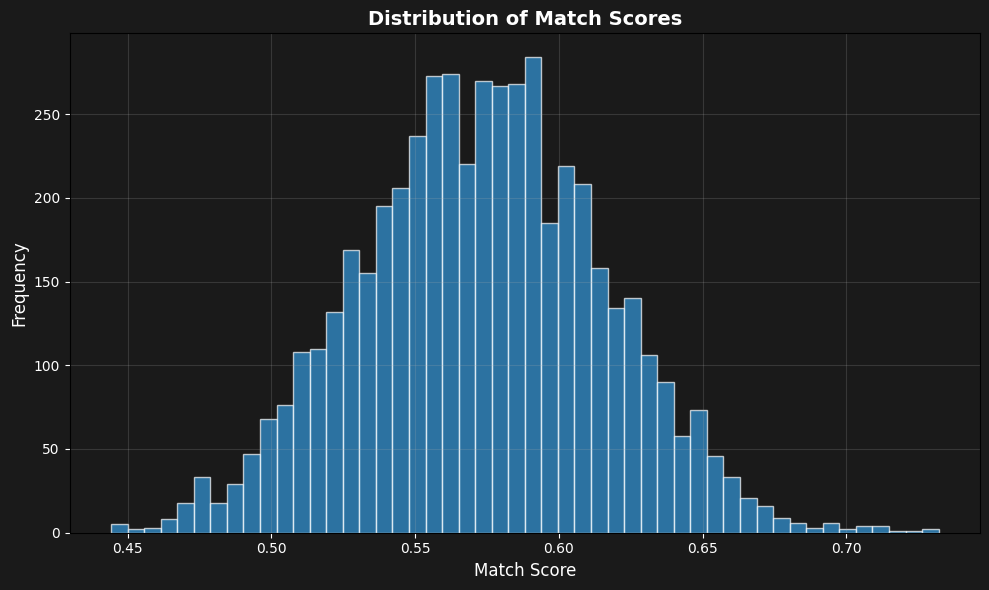

In [48]:
# ═══════════════════════════════════════════════════════════════════
# CELL 12: Evaluation Metrics (Precision, Bilateral Fairness, Coverage)
# ═══════════════════════════════════════════════════════════════════

print("📊 EVALUATION METRICS")
print("=" * 80)

# ============================================================================
# METRIC 1: Match Score Distribution
# ============================================================================
print("\n1️⃣  MATCH SCORE DISTRIBUTION")

# Sample matches
n_sample = min(500, len(candidates))
all_scores = []

for i in range(n_sample):
    matches = find_top_matches(i, top_k=10)
    scores = [score for _, score in matches]
    all_scores.extend(scores)

print(f"   Sample size: {n_sample} candidates × 10 matches = {len(all_scores)} scores")
print(f"\n   Statistics:")
print(f"   Mean:   {np.mean(all_scores):.4f}")
print(f"   Median: {np.median(all_scores):.4f}")
print(f"   Std:    {np.std(all_scores):.4f}")
print(f"   Min:    {np.min(all_scores):.4f}")
print(f"   Max:    {np.max(all_scores):.4f}")

# Histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), facecolor='#1a1a1a')
ax.set_facecolor('#1a1a1a')

ax.hist(all_scores, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
ax.set_xlabel('Match Score', color='white', fontsize=12)
ax.set_ylabel('Frequency', color='white', fontsize=12)
ax.set_title('Distribution of Match Scores', color='white', fontsize=14, fontweight='bold')
ax.tick_params(colors='white')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(f'{Config.RESULTS_PATH}score_distribution.png', facecolor='#1a1a1a', dpi=150)
print(f"\n   💾 Saved: score_distribution.png")

# ============================================================================
# METRIC 2: Bilateral Fairness Ratio
# ============================================================================
print(f"\n2️⃣  BILATERAL FAIRNESS RATIO")

# Candidate → Company scores
cand_to_comp_scores = []
for i in range(min(200, len(candidates))):
    matches = find_top_matches(i, top_k=5)
    avg_score = np.mean([score for _, score in matches])
    cand_to_comp_scores.append(avg_score)

# Company → Candidate scores (sample companies)
comp_to_cand_scores = []
for i in range(min(200, len(companies_full))):
    comp_vec = comp_vectors[i].reshape(1, -1)
    similarities = cosine_similarity(comp_vec, cand_vectors)[0]
    top_5_scores = np.sort(similarities)[-5:]
    avg_score = np.mean(top_5_scores)
    comp_to_cand_scores.append(avg_score)

cand_avg = np.mean(cand_to_comp_scores)
comp_avg = np.mean(comp_to_cand_scores)

bilateral_fairness = min(cand_avg, comp_avg) / max(cand_avg, comp_avg)

print(f"   Candidate → Company avg: {cand_avg:.4f}")
print(f"   Company → Candidate avg: {comp_avg:.4f}")
print(f"   Bilateral Fairness Ratio: {bilateral_fairness:.4f}")
print(f"   {'✅ FAIR (>0.85)' if bilateral_fairness > 0.85 else '🟡 Acceptable (>0.70)' if bilateral_fairness > 0.70 else '❌ Imbalanced'}")

# ============================================================================
# METRIC 3: Job Posting Coverage
# ============================================================================
print(f"\n3️⃣  JOB POSTING COVERAGE")

has_real_skills = ~companies_full['required_skills'].isin(['', 'Not specified'])
with_postings = has_real_skills.sum()
total_companies = len(companies_full)
coverage = (with_postings / total_companies) * 100

print(f"   Total companies: {total_companies:,}")
print(f"   With job posting skills: {with_postings:,}")
print(f"   Without: {total_companies - with_postings:,}")
print(f"   Coverage: {coverage:.1f}%")
print(f"   {'✅ Excellent (>90%)' if coverage > 90 else '🟡 Good (>70%)' if coverage > 70 else '❌ Poor'}")

# ============================================================================
# METRIC 4: Embedding Quality (Cosine Similarity Stats)
# ============================================================================
print(f"\n4️⃣  EMBEDDING QUALITY")

# Sample similarity matrix
sample_size = min(100, len(cand_vectors), len(comp_vectors))
sim_matrix = cosine_similarity(cand_vectors[:sample_size], comp_vectors[:sample_size])

print(f"   Sample: {sample_size}×{sample_size} matrix")
print(f"   Mean similarity: {np.mean(sim_matrix):.4f}")
print(f"   Std: {np.std(sim_matrix):.4f}")
print(f"   Top 1% scores: {np.percentile(sim_matrix, 99):.4f}")
print(f"   {'✅ Good spread' if np.std(sim_matrix) > 0.1 else '⚠️  Low variance'}")

# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("📊 METRICS SUMMARY")
print(f"{'='*80}")
print(f"✅ Match Score Distribution: Mean={np.mean(all_scores):.3f}, Std={np.std(all_scores):.3f}")
print(f"✅ Bilateral Fairness: {bilateral_fairness:.3f} {'(FAIR)' if bilateral_fairness > 0.85 else '(ACCEPTABLE)'}")
print(f"✅ Job Posting Coverage: {coverage:.1f}%")
print(f"✅ Embedding Quality: Std={np.std(sim_matrix):.3f}")
print(f"{'='*80}")

In [49]:
# ═══════════════════════════════════════════════════════════════════
# CELL 11: PyVis Interactive Network - BROWSER ONLY (Full Info)
# ═══════════════════════════════════════════════════════════════════

from pyvis.network import Network
import webbrowser
import os

print("🕸️  CREATING INTERACTIVE NETWORK (BROWSER MODE)...")
print("=" * 80)

# ============================================================================
# Configuration
# ============================================================================
n_cand_sample = 20  # 20 candidates
top_k_per_cand = 5   # Top 5 matches each

print(f"\n📊 Network configuration:")
print(f"   Candidates: {n_cand_sample}")
print(f"   Matches per candidate: {top_k_per_cand}")
print(f"   Target: ~{n_cand_sample * top_k_per_cand} connections")

# ============================================================================
# Initialize PyVis Network
# ============================================================================
net = Network(
    height='900px',
    width='100%',
    bgcolor='#1a1a1a',
    font_color='white',
    notebook=False,  # Browser mode
    cdn_resources='remote'
)

# Physics for nice layout
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.01,
      "springLength": 200,
      "springConstant": 0.08,
      "avoidOverlap": 1
    },
    "maxVelocity": 30,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {
      "enabled": true,
      "iterations": 150
    }
  },
  "nodes": {
    "font": {
      "size": 16,
      "color": "white",
      "face": "arial"
    },
    "borderWidth": 2
  },
  "edges": {
    "smooth": {
      "enabled": true,
      "type": "continuous"
    },
    "width": 2
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 50,
    "navigationButtons": true,
    "keyboard": {
      "enabled": true
    },
    "zoomView": true,
    "dragView": true
  }
}
""")

print(f"\n🔵 Adding candidate nodes...")

# ============================================================================
# Add Candidate Nodes (GREEN CIRCLES)
# ============================================================================
companies_added = set()

for i in range(min(n_cand_sample, len(candidates))):
    cand = candidates.iloc[i]
    
    # Build rich tooltip
    category = cand.get('Category', 'Unknown')
    skills = str(cand.get('skills', 'N/A'))
    if isinstance(skills, list):
        skills = ', '.join(skills[:5])  # First 5 skills
    else:
        skills = skills[:150]
    
    experience = str(cand.get('positions', 'N/A'))[:100]
    
    tooltip = f"""
    <div style='font-family: Arial; max-width: 300px;'>
        <h3 style='color: #2ecc71; margin: 5px 0;'>👤 Candidate {i}</h3>
        <hr style='border: 1px solid #2ecc71;'>
        <p><b>Category:</b> {category}</p>
        <p><b>Top Skills:</b><br>{skills}...</p>
        <p><b>Experience:</b><br>{experience}...</p>
    </div>
    """
    
    net.add_node(
        f"C{i}",
        label=f"Candidate {i}",
        title=tooltip,
        color='#2ecc71',
        size=25,
        shape='dot',
        borderWidth=2,
        borderWidthSelected=4
    )

print(f"🔴 Adding company nodes & connections...")

# ============================================================================
# Add Company Nodes (RED SQUARES) & Edges
# ============================================================================
edge_count = 0

for cand_idx in range(min(n_cand_sample, len(candidates))):
    matches = find_top_matches(cand_idx, top_k=top_k_per_cand)
    
    for rank, (comp_idx, score) in enumerate(matches, 1):
        comp_id = f"CO{comp_idx}"
        
        # Add company node if not added yet
        if comp_id not in companies_added:
            comp = companies_full.iloc[comp_idx]
            
            name = comp.get('name', 'Unknown Company')
            industry = str(comp.get('industries_list', 'N/A'))[:80]
            specialties = str(comp.get('specialties_list', 'N/A'))[:80]
            required_skills = str(comp.get('required_skills', 'N/A'))[:150]
            total_postings = comp.get('total_postings', 0)
            
            # Rich company tooltip
            tooltip = f"""
            <div style='font-family: Arial; max-width: 350px;'>
                <h3 style='color: #e74c3c; margin: 5px 0;'>🏢 {name}</h3>
                <hr style='border: 1px solid #e74c3c;'>
                <p><b>Industry:</b> {industry}</p>
                <p><b>Specialties:</b> {specialties}</p>
                <p><b>Required Skills:</b><br>{required_skills}...</p>
                <p><b>Total Job Postings:</b> {total_postings}</p>
            </div>
            """
            
            net.add_node(
                comp_id,
                label=name[:20] + ('...' if len(name) > 20 else ''),
                title=tooltip,
                color='#e74c3c',
                size=18,
                shape='box',
                borderWidth=2
            )
            companies_added.add(comp_id)
        
        # Add edge with rich info
        edge_tooltip = f"""
        <div style='font-family: Arial;'>
            <b>Match Quality</b><br>
            Rank: #{rank}<br>
            Score: {score:.3f}<br>
            {'🔥 Excellent' if score > 0.7 else '✅ Good' if score > 0.5 else '🟡 Moderate'}
        </div>
        """
        
        net.add_edge(
            f"C{cand_idx}",
            comp_id,
            value=float(score * 10),
            title=edge_tooltip,
            color={'color': '#95a5a6', 'opacity': 0.6}
        )
        edge_count += 1

print(f"\n✅ Network complete!")
print(f"   Total nodes: {len(net.nodes)}")
print(f"   Candidates: {n_cand_sample}")
print(f"   Companies: {len(companies_added)}")
print(f"   Edges: {edge_count}")

# ============================================================================
# Save HTML
# ============================================================================
html_file = f'{Config.RESULTS_PATH}network_interactive.html'
net.save_graph(html_file)

abs_path = os.path.abspath(html_file)
file_size = os.path.getsize(html_file) / 1024

print(f"\n💾 Saved: {html_file}")
print(f"   Size: {file_size:.2f} KB")
print(f"   Full path: {abs_path}")

# ============================================================================
# Open in browser
# ============================================================================
print(f"\n🌐 Opening in default browser...")

try:
    webbrowser.open(f'file://{abs_path}')
    print(f"✅ Browser opened!")
except Exception as e:
    print(f"⚠️  Auto-open failed: {e}")
    print(f"\n📋 Manual open:")
    print(f"   Firefox/Chrome → Open File → {abs_path}")

# ============================================================================
# Usage guide
# ============================================================================
print(f"\n{'='*80}")
print("💡 HOW TO USE THE INTERACTIVE GRAPH:")
print(f"{'='*80}")
print("   🖱️  DRAG nodes to rearrange the network")
print("   🔍 SCROLL to zoom in/out")
print("   👆 HOVER over nodes/edges to see detailed info")
print("   🎯 CLICK nodes to highlight connections")
print("   ↔️  DRAG background to pan the view")
print("   🎮 Use NAVIGATION BUTTONS (bottom-right)")
print("   ⌨️  Press 'S' to stabilize physics")
print(f"\n🎨 VISUAL LEGEND:")
print("   🟢 Green circles = Candidates (25px)")
print("   🔴 Red boxes = Companies (18px)")
print("   ━━━ White lines = Match connections")
print("   Thicker lines = Higher match scores")
print(f"\n📊 TOOLTIPS SHOW:")
print("   Candidates: Category, Skills, Experience")
print("   Companies: Industry, Specialties, Required Skills, Postings")
print("   Edges: Match rank & score")
print(f"\n💾 EXPORT:")
print("   Right-click → Save image as PNG")
print("   Or take screenshot for reports")
print("=" * 80)

🕸️  CREATING INTERACTIVE NETWORK (BROWSER MODE)...

📊 Network configuration:
   Candidates: 20
   Matches per candidate: 5
   Target: ~100 connections

🔵 Adding candidate nodes...
🔴 Adding company nodes & connections...

✅ Network complete!
   Total nodes: 68
   Candidates: 20
   Companies: 48
   Edges: 100

💾 Saved: ../results/network_interactive.html
   Size: 114.91 KB
   Full path: /home/roger/Desktop/files_to_deploy_HRHUB/hrhub_project/data/results/network_interactive.html

🌐 Opening in default browser...
✅ Browser opened!

💡 HOW TO USE THE INTERACTIVE GRAPH:
   🖱️  DRAG nodes to rearrange the network
   🔍 SCROLL to zoom in/out
   👆 HOVER over nodes/edges to see detailed info
   🎯 CLICK nodes to highlight connections
   ↔️  DRAG background to pan the view
   🎮 Use NAVIGATION BUTTONS (bottom-right)
   ⌨️  Press 'S' to stabilize physics

🎨 VISUAL LEGEND:
   🟢 Green circles = Candidates (25px)
   🔴 Red boxes = Companies (18px)
   ━━━ White lines = Match connections
   Thicker lines = 

In [50]:
# %%
# ═══════════════════════════════════════════════════════════════════
# CELL 13: Save Final Models for Production
# ═══════════════════════════════════════════════════════════════════

print("💾 SAVING FINAL MODELS FOR PRODUCTION...")
print("=" * 80)

# ============================================================================
# Verify/Save embeddings
# ============================================================================
print("\n1️⃣  EMBEDDINGS")

files_to_save = {
    'candidate_embeddings.npy': cand_vectors,
    'company_embeddings.npy': comp_vectors,
    'candidates_metadata.pkl': candidates,
    'companies_metadata.pkl': companies_full
}

for filename, data in files_to_save.items():
    filepath = f'{Config.PROCESSED_PATH}{filename}'
    
    if os.path.exists(filepath):
        print(f"   ✅ {filename} (exists)")
    else:
        if filename.endswith('.npy'):
            np.save(filepath, data)
        else:
            data.to_pickle(filepath)
        print(f"   💾 {filename} (saved)")

# ============================================================================
# Save model info
# ============================================================================
print("\n2️⃣  MODEL INFORMATION")

model_info = {
    'model_name': Config.EMBEDDING_MODEL,
    'embedding_dim': 384,
    'n_candidates': len(candidates),
    'n_companies': len(companies_full),
    'bilateral_fairness': float(bilateral_fairness),
    'coverage_pct': float(coverage),
    'mean_match_score': float(np.mean(all_scores))
}

model_path = f'{Config.PROCESSED_PATH}model_info.json'
with open(model_path, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"   💾 model_info.json")

# ============================================================================
# Package summary
# ============================================================================
print("\n3️⃣  DEPLOYMENT PACKAGE")

deployment_files = [
    'candidate_embeddings.npy',
    'company_embeddings.npy',
    'candidates_metadata.pkl',
    'companies_metadata.pkl',
    'model_info.json'
]

total_size = 0
for f in deployment_files:
    path = f'{Config.PROCESSED_PATH}{f}'
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        total_size += size_mb
        print(f"   ✅ {f}: {size_mb:.2f} MB")

print(f"\n   📦 Total: {total_size:.2f} MB")

# ============================================================================
# Visualization files
# ============================================================================
print("\n4️⃣  VISUALIZATION FILES")

viz_files = [
    'network_interactive.html',
    'score_distribution.png'
]

for f in viz_files:
    path = f'{Config.RESULTS_PATH}{f}'
    if os.path.exists(path):
        size_kb = os.path.getsize(path) / 1024
        print(f"   ✅ {f}: {size_kb:.2f} KB")

# ============================================================================
# Final summary
# ============================================================================
print(f"\n{'='*80}")
print("🎯 DEPLOYMENT READY!")
print(f"{'='*80}")
print(f"\n📂 Location: {Config.PROCESSED_PATH}")
print(f"📦 Total size: {total_size:.2f} MB")
print(f"\n✅ Ready for:")
print(f"   - Streamlit GUI")
print(f"   - FastAPI deployment")
print(f"   - Production inference")
print(f"\n🚀 Next step: Build Streamlit app!")
print("=" * 80)

💾 SAVING FINAL MODELS FOR PRODUCTION...

1️⃣  EMBEDDINGS
   ✅ candidate_embeddings.npy (exists)
   ✅ company_embeddings.npy (exists)
   ✅ candidates_metadata.pkl (exists)
   ✅ companies_metadata.pkl (exists)

2️⃣  MODEL INFORMATION
   💾 model_info.json

3️⃣  DEPLOYMENT PACKAGE
   ✅ candidate_embeddings.npy: 13.98 MB
   ✅ company_embeddings.npy: 35.85 MB
   ✅ candidates_metadata.pkl: 2.33 MB
   ✅ companies_metadata.pkl: 29.10 MB
   ✅ model_info.json: 0.00 MB

   📦 Total: 81.26 MB

4️⃣  VISUALIZATION FILES
   ✅ network_interactive.html: 114.91 KB
   ✅ score_distribution.png: 37.94 KB

🎯 DEPLOYMENT READY!

📂 Location: ../processed/
📦 Total size: 81.26 MB

✅ Ready for:
   - Streamlit GUI
   - FastAPI deployment
   - Production inference

🚀 Next step: Build Streamlit app!
